In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import os
import warnings
import sys
import matplotlib.pyplot as plt

In [3]:
sys.path.append('/home/mondzi259/Apna_Assignment/src/ml_auto/')

In [4]:
from custom_estimator import Estimator, scoring_metric
from encoding import FreqeuncyEncoding,TargetEncoding
from hyperopt_model_selection import HyperOptModelSelection,hp
from custom_fold_generator import KFold,GroupKFold,CustomFolds
from lightgbm import LGBMRegressor

In [5]:
warnings.filterwarnings('ignore')

In [6]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [7]:
DATA_DIR = '/home/mondzi259/Apna_Assignment/data/'

In [8]:
df = pd.read_excel(os.path.join(DATA_DIR,'data.xlsx'),sheet_name=0)
df.shape

(30000, 19)

In [9]:
df.drop('feebackgiven',axis=1,inplace=True)

In [10]:
data_dic = pd.read_excel(os.path.join(DATA_DIR,'data.xlsx'),sheet_name=1,header=None)

In [11]:
data_dic

,0,1,2,3
0,lead,A candidate who has interacted with HR on the ...,NaN,NaN
1,shift,night/ day,"0 - day, 1 - night",NaN
2,gender,f/m/all,"0 - male jobs, 1 - female , 2 - all",NaN
3,education,10th to PG,"ordinally placed, 10th being lowest and PG the...",NaN
4,created_on,job created date,Days since a fixed reference data,"For ex: if reference data was 1 Jan 2020,\njob..."
5,employer_type,key-account/ smb/ enterprise/ consultant/ NA,"most jobs are smb, followed by Key accounts, e...",NaN
6,applicant_location,candidate distance from job,"lower the value, lower the distance requirement",NaN
7,city,city,is masked,NaN
8,area,area,is masked,NaN
9,organization,company name,is masked,NaN


In [12]:
df.head()

,shift,gender,education,created_on,dow,employer_type,applicant_location,city,area,organization,deposit,category,english,num_openings,max_salary,min_salary,is_part_time,leads_per_opening
0,0.0,0.0,3.0,413.0,3.0,0.0,0.0,1.0,4119.0,31278.0,0.0,55.0,2.0,22.0,21000.0,NaN,0.0,0.090909
1,0.0,0.0,3.0,529.0,0.0,4.0,0.0,2.0,2017.0,32006.0,0.0,54.0,2.0,2.0,80000.0,NaN,0.0,31.500000
2,0.0,0.0,0.0,457.0,0.0,4.0,0.0,3.0,1500.0,32029.0,0.0,42.0,3.0,1.0,3500.0,NaN,1.0,9.000000
3,0.0,0.0,4.0,450.0,3.0,4.0,0.0,5.0,638.0,9925.0,0.0,60.0,4.0,4.0,11500.0,NaN,0.0,0.000000
4,0.0,0.0,0.0,480.0,0.0,1.0,0.0,2.0,4115.0,8400.0,0.0,16.0,3.0,25.0,25000.0,NaN,0.0,1.400000


### Target vs created_on

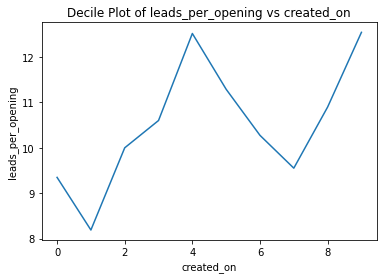

In [13]:
df.groupby(pd.qcut(df['created_on'],10,
                   duplicates='drop',labels=False))['leads_per_opening'].mean().plot()
plt.ylabel('leads_per_opening')
plt.title('Decile Plot of leads_per_opening vs created_on');

### Ideas:

1. CV: Time series, KFold, GKFold
2. log transform targets: business sense and outliers
3. cat OHE, LE, FE, TE
4. cat num agg
5. num num agg
6. missing min salary; app location=0; imputation w/wo
7. bayesian fs
8. API
9. Explainability
10. Local/Global feature importance
11. Outliers/score
12. clustering, svd, cluster distance
13. time based (created on) aggs

### 

In [14]:
num_cols = ['leads_per_opening','max_salary','min_salary','deposit','num_openings','created_on']
cat_cols = [i for i in df.columns.tolist() if i not in num_cols]
cat_ordinal_cols = ['applicant_location','english','education']
cat_non_ord_cols = [i for i in cat_cols if i not in cat_ordinal_cols]

In [15]:
cat_non_ord_cols,cat_ordinal_cols

(['shift',
  'gender',
  'dow',
  'employer_type',
  'city',
  'area',
  'organization',
  'category',
  'is_part_time'],
 ['applicant_location', 'english', 'education'])

In [16]:
df[cat_cols].nunique()

shift                     2
gender                    3
education                 6
dow                       7
employer_type             5
applicant_location        4
city                      7
area                   2740
organization          14886
category                 67
english                   4
is_part_time              2
dtype: int64

In [17]:
class FreqEnc:
    def __init__(self,cat_freq_cols):
        self.cat_freq_cols = cat_freq_cols
    def fit(self,df):
        self.freq_encoding_dict = {
                x: df[x].value_counts(1).to_dict() for x in self.cat_freq_cols
            }
    def transform(self,df):
        for col in self.cat_freq_cols:
            df[col+"_fe"] = df[col].map(self.freq_encoding_dict[col]).fillna(0)
        return df
    def fit_transform(self,df):
        self.fit(df)
        return self.transform(df)

In [18]:
df=df.sort_values('created_on').reset_index(drop=True)

In [19]:
df.shape

(30000, 18)

In [20]:
df['target'] = np.log1p(df.leads_per_opening)

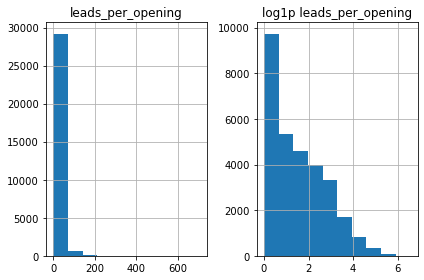

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(6, 4))
df.leads_per_opening.hist(ax=axes[0])
axes[0].set_title('leads_per_opening')
df.target.hist(ax=axes[1])
axes[1].set_title('log1p leads_per_opening')
plt.tight_layout()

In [22]:
df.target.describe()

count    30000.000000
mean         1.507317
std          1.264234
min          0.000000
25%          0.385158
50%          1.299283
75%          2.397895
max          6.559615
Name: target, dtype: float64

### Removing outliers from data

In [23]:
df.target.describe(percentiles=[.75,.9,.95,.99])

count    30000.000000
mean         1.507317
std          1.264234
min          0.000000
50%          1.299283
75%          2.397895
90%          3.295837
95%          3.850148
99%          4.770727
max          6.559615
Name: target, dtype: float64

In [24]:
df= df[df.target<4.753590].reset_index(drop=True)
df.shape

(29680, 19)

In [25]:
folds =[
    (df[(df.created_on<=df.created_on.quantile(0.7))].index.tolist(),\
df[(df.created_on>df.created_on.quantile(0.7))&\
      (df.created_on<=df.created_on.quantile(0.8))].index.tolist()),
    
    (df[(df.created_on>=df.created_on.quantile(0.1))&\
      (df.created_on<=df.created_on.quantile(0.8))].index.tolist(),\
df[(df.created_on>df.created_on.quantile(0.8))&\
      (df.created_on<=df.created_on.quantile(0.9))].index.tolist()),
    
    (df[(df.created_on>=df.created_on.quantile(0.2))&\
      (df.created_on<=df.created_on.quantile(0.9))].index.tolist(),\
df[(df.created_on>df.created_on.quantile(0.9))&\
      (df.created_on<=df.created_on.quantile(1))].index.tolist())
]

In [26]:
[(df.iloc[i].shape[0]/df.shape[0],df.iloc[j].shape[0]/df.shape[0]) for i,j in folds]

[(0.7054582210242588, 0.10107816711590296),
 (0.7071091644204852, 0.09508086253369272),
 (0.7022237196765498, 0.09838274932614555)]

In [27]:
fe = FreqEnc(cat_freq_cols=cat_non_ord_cols)

In [28]:
df = fe.fit_transform(df)

In [29]:
target = df.target.values

In [30]:
df.shape

(29680, 28)

In [31]:
remove_cols = cat_non_ord_cols + ['target','leads_per_opening']

In [32]:
use_cols = [i for i in df.columns if i not in remove_cols]

In [33]:
use_cols

['education',
 'created_on',
 'applicant_location',
 'deposit',
 'english',
 'num_openings',
 'max_salary',
 'min_salary',
 'shift_fe',
 'gender_fe',
 'dow_fe',
 'employer_type_fe',
 'city_fe',
 'area_fe',
 'organization_fe',
 'category_fe',
 'is_part_time_fe']

In [ ]:
lgbm_space = {
#    'learning_rate': hp.quniform('learning_rate', 0.025, 0.1, 0.025),
    'n_estimators': 10000,
#     'early_stopping_rounds': 100,
    'num_leaves':  hp.quniform('num_leaves', 16, 80, 16),
#     'min_child_weight': hp.quniform('min_child_weight', 1, 40, 5),
    'min_child_samples': hp.quniform('min_child_samples', 1, 240, 40),
    'subsample': hp.quniform('subsample', 0.2, 1, 0.2),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.2, 1, 0.2),
    'subsample_freq': hp.choice('subsample_freq',[5]),
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'n_jobs': -1
}

In [39]:
hyp = HyperOptModelSelection(Estimator(model=LGBMRegressor(),
                                       early_stopping_rounds=100,
                                       validation_scheme=folds,
                                       shuffle=True),
                             space= lgbm_space,
                             max_evals=200,is_maximize=False,random_seed=100,
                             params_mapping = {'n_estimators':int, 'num_leaves':int, 
                                               'max_depth':int,'min_child_samples':int},          
                             log_file_path="hyperopt_log.txt")

In [40]:
hyp.fit(df[use_cols].values,target)

Starting HyperOpt 200 Evals with Dataset of Shape ((27033, 17),(27033,))


  0%|                                                                   | 0/200 [00:00<?, ?trial/s, best loss=?]


Iteration: 1, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.843146	valid_0's l2: 0.710895	valid_1's rmse: 0.826759	valid_1's l2: 0.68353            
[200]	valid_0's rmse: 0.839825	valid_0's l2: 0.705306	valid_1's rmse: 0.785948	valid_1's l2: 0.617714           
[100]	valid_0's rmse: 0.911732	valid_0's l2: 0.831255	valid_1's rmse: 0.820455	valid_1's l2: 0.673146           
[200]	valid_0's rmse: 0.909928	valid_0's l2: 0.827969	valid_1's rmse: 0.77926	valid_1's l2: 0.607247            
[100]	valid_0's rmse: 0.838781	valid_0's l2: 0.703553	valid_1's rmse: 0.824825	valid_1's l2: 0.680336           
[200]	valid_0's rmse: 0.826947	valid_0's l2: 0.683841	valid_1's rmse: 0.785099	valid_1's l2: 0.616381           
[300]	valid_0's rmse: 0.82245	valid_0's l2: 0.676424	valid_1's rmse: 0.759297	valid_1's l2: 0.576532            
[400]	valid_0's rmse: 0.822764	valid_0's l2: 0.67694	valid_1's rmse: 0.738832	valid_1's l2: 0.545872            
  0%|                                                                   | 0/200 [00:01<?, ?trial

Score - 0.8567838652780191, Std - 0.038109064632184414, Eval Score - 0.8567838652780191
Score across folds - [0.8386262711666884, 0.9098078275145794, 0.8219174971527896].


  0%|▏                                        | 1/200 [00:02<06:44,  2.03s/trial, best loss: 0.8567838652780191]


Iteration: 2, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.845115	valid_0's l2: 0.714219	valid_1's rmse: 0.807275	valid_1's l2: 0.651692           
[200]	valid_0's rmse: 0.847418	valid_0's l2: 0.718117	valid_1's rmse: 0.760912	valid_1's l2: 0.578988           
[100]	valid_0's rmse: 0.922139	valid_0's l2: 0.85034	valid_1's rmse: 0.798298	valid_1's l2: 0.63728             
[200]	valid_0's rmse: 0.926151	valid_0's l2: 0.857757	valid_1's rmse: 0.75101	valid_1's l2: 0.564017            
[100]	valid_0's rmse: 0.83978	valid_0's l2: 0.70523	valid_1's rmse: 0.806629	valid_1's l2: 0.65065              
[200]	valid_0's rmse: 0.83059	valid_0's l2: 0.68988	valid_1's rmse: 0.757969	valid_1's l2: 0.574517             
  0%|▏                                        | 1/200 [00:03<06:44,  2.03s/trial, best loss: 0.8567838652780191]

Score - 0.8630428033929154, Std - 0.038409104209696746, Eval Score - 0.8630428033929154
Score across folds - [0.8420180557876843, 0.916929811722974, 0.8301805426680877].


  1%|▍                                        | 2/200 [00:03<06:08,  1.86s/trial, best loss: 0.8567838652780191]


Iteration: 3, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 60, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.842129	valid_0's l2: 0.709181	valid_1's rmse: 0.798144	valid_1's l2: 0.637034           
[200]	valid_0's rmse: 0.843847	valid_0's l2: 0.712077	valid_1's rmse: 0.745446	valid_1's l2: 0.555689           
[100]	valid_0's rmse: 0.925276	valid_0's l2: 0.856136	valid_1's rmse: 0.790954	valid_1's l2: 0.625609           
[200]	valid_0's rmse: 0.923457	valid_0's l2: 0.852773	valid_1's rmse: 0.738745	valid_1's l2: 0.545745           
[100]	valid_0's rmse: 0.841123	valid_0's l2: 0.707489	valid_1's rmse: 0.797028	valid_1's l2: 0.635253           
[200]	valid_0's rmse: 0.830385	valid_0's l2: 0.689539	valid_1's rmse: 0.743545	valid_1's l2: 0.552859           
[300]	valid_0's rmse: 0.835512	valid_0's l2: 0.69808	valid_1's rmse: 0.704785	valid_1's l2: 0.496721            
  1%|▍                                        | 2/200 [00:05<06:08,  1.86s/trial, best loss: 0.8567838652780191]

Score - 0.8632775651747466, Std - 0.03960490479068838, Eval Score - 0.8632775651747466
Score across folds - [0.8408052213300298, 0.9189442226539033, 0.830083251540307].


  2%|▌                                        | 3/200 [00:05<05:58,  1.82s/trial, best loss: 0.8567838652780191]


Iteration: 4, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 60, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.84561	valid_0's l2: 0.715055	valid_1's rmse: 0.845582	valid_1's l2: 0.715008            
[200]	valid_0's rmse: 0.838239	valid_0's l2: 0.702645	valid_1's rmse: 0.808691	valid_1's l2: 0.653982           
[300]	valid_0's rmse: 0.836284	valid_0's l2: 0.699371	valid_1's rmse: 0.783856	valid_1's l2: 0.614429           
[100]	valid_0's rmse: 0.927088	valid_0's l2: 0.859492	valid_1's rmse: 0.839139	valid_1's l2: 0.704154           
[200]	valid_0's rmse: 0.920092	valid_0's l2: 0.846569	valid_1's rmse: 0.801097	valid_1's l2: 0.641757           
[100]	valid_0's rmse: 0.853249	valid_0's l2: 0.728033	valid_1's rmse: 0.844808	valid_1's l2: 0.713701           
[200]	valid_0's rmse: 0.835429	valid_0's l2: 0.697941	valid_1's rmse: 0.807941	valid_1's l2: 0.652769           
[300]	valid_0's rmse: 0.833017	valid_0's l2: 0.693918	valid_1's rmse: 0.783175	valid_1's l2: 0.613363           
[400]	valid_0's rmse: 0.832167	valid_0's l2: 0.692502	valid_1's rmse: 0.762656	valid_1's l2: 0.5

Score - 0.8617841235964838, Std - 0.040789847320213304, Eval Score - 0.8617841235964838
Score across folds - [0.834972728426304, 0.9194230584967512, 0.8309565838663961].


  2%|▊                                        | 4/200 [00:07<05:47,  1.77s/trial, best loss: 0.8567838652780191]


Iteration: 5, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 60, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.849159	valid_0's l2: 0.721071	valid_1's rmse: 0.842591	valid_1's l2: 0.709959           
[200]	valid_0's rmse: 0.840688	valid_0's l2: 0.706756	valid_1's rmse: 0.805795	valid_1's l2: 0.649305           
[300]	valid_0's rmse: 0.841827	valid_0's l2: 0.708672	valid_1's rmse: 0.780369	valid_1's l2: 0.608975           
[100]	valid_0's rmse: 0.922852	valid_0's l2: 0.851657	valid_1's rmse: 0.837519	valid_1's l2: 0.701438           
[200]	valid_0's rmse: 0.928636	valid_0's l2: 0.862364	valid_1's rmse: 0.800948	valid_1's l2: 0.641518           
[100]	valid_0's rmse: 0.850649	valid_0's l2: 0.723604	valid_1's rmse: 0.843924	valid_1's l2: 0.712208           
[200]	valid_0's rmse: 0.832391	valid_0's l2: 0.692874	valid_1's rmse: 0.805615	valid_1's l2: 0.649015           
[300]	valid_0's rmse: 0.834965	valid_0's l2: 0.697167	valid_1's rmse: 0.780235	valid_1's l2: 0.608767           
  2%|▊                                        | 4/200 [00:08<05:47,  1.77s/trial, best loss: 0.8

Score - 0.8637277455952855, Std - 0.04089935530006642, Eval Score - 0.8637277455952855
Score across folds - [0.8385507866342856, 0.9214130813858289, 0.8312193687657421].


  2%|█                                        | 5/200 [00:08<05:16,  1.62s/trial, best loss: 0.8567838652780191]


Iteration: 6, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 40, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.847901	valid_0's l2: 0.718936	valid_1's rmse: 0.797579	valid_1's l2: 0.636133           
[200]	valid_0's rmse: 0.851554	valid_0's l2: 0.725145	valid_1's rmse: 0.74484	valid_1's l2: 0.554787            
[100]	valid_0's rmse: 0.921871	valid_0's l2: 0.849846	valid_1's rmse: 0.791275	valid_1's l2: 0.626117           
[200]	valid_0's rmse: 0.919295	valid_0's l2: 0.845103	valid_1's rmse: 0.737389	valid_1's l2: 0.543743           
[100]	valid_0's rmse: 0.840338	valid_0's l2: 0.706167	valid_1's rmse: 0.800269	valid_1's l2: 0.64043            
[200]	valid_0's rmse: 0.828071	valid_0's l2: 0.685701	valid_1's rmse: 0.74643	valid_1's l2: 0.557158            
[300]	valid_0's rmse: 0.836152	valid_0's l2: 0.69915	valid_1's rmse: 0.706204	valid_1's l2: 0.498724            
  2%|█                                        | 5/200 [00:10<05:16,  1.62s/trial, best loss: 0.8567838652780191]

Score - 0.8631747482791622, Std - 0.03857104971943213, Eval Score - 0.8631747482791622
Score across folds - [0.8450384518779536, 0.9167950555668859, 0.8276907373926473].


  3%|█▏                                       | 6/200 [00:10<05:20,  1.65s/trial, best loss: 0.8567838652780191]


Iteration: 7, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.840045	valid_0's l2: 0.705676	valid_1's rmse: 0.807569	valid_1's l2: 0.652168           
[200]	valid_0's rmse: 0.842605	valid_0's l2: 0.709983	valid_1's rmse: 0.762432	valid_1's l2: 0.581303           
[100]	valid_0's rmse: 0.930802	valid_0's l2: 0.866393	valid_1's rmse: 0.800011	valid_1's l2: 0.640018           
[100]	valid_0's rmse: 0.83921	valid_0's l2: 0.704273	valid_1's rmse: 0.805619	valid_1's l2: 0.649021            
[200]	valid_0's rmse: 0.828384	valid_0's l2: 0.686221	valid_1's rmse: 0.75964	valid_1's l2: 0.577053            
  3%|█▏                                       | 6/200 [00:11<05:20,  1.65s/trial, best loss: 0.8567838652780191]

Score - 0.8654024319123991, Std - 0.04542742717076477, Eval Score - 0.8654024319123991
Score across folds - [0.8388027077786263, 0.9293463234007098, 0.828058264557861].


  4%|█▍                                       | 7/200 [00:11<05:14,  1.63s/trial, best loss: 0.8567838652780191]


Iteration: 8, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 100, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.848088	valid_0's l2: 0.719254	valid_1's rmse: 0.812522	valid_1's l2: 0.660191           
[200]	valid_0's rmse: 0.845033	valid_0's l2: 0.714081	valid_1's rmse: 0.769032	valid_1's l2: 0.59141            
[100]	valid_0's rmse: 0.919915	valid_0's l2: 0.846244	valid_1's rmse: 0.805513	valid_1's l2: 0.64885            
[200]	valid_0's rmse: 0.917144	valid_0's l2: 0.841153	valid_1's rmse: 0.762726	valid_1's l2: 0.58175            
[100]	valid_0's rmse: 0.840976	valid_0's l2: 0.70724	valid_1's rmse: 0.812525	valid_1's l2: 0.660197            
[200]	valid_0's rmse: 0.826459	valid_0's l2: 0.683035	valid_1's rmse: 0.767585	valid_1's l2: 0.589187           
[300]	valid_0's rmse: 0.827486	valid_0's l2: 0.684733	valid_1's rmse: 0.734518	valid_1's l2: 0.539517           
  4%|█▍                                       | 7/200 [00:13<05:14,  1.63s/trial, best loss: 0.8567838652780191]

Score - 0.8606566762215085, Std - 0.03742781322656382, Eval Score - 0.8606566762215085
Score across folds - [0.8439679497855629, 0.9125024947236835, 0.825499584155279].


  4%|█▋                                       | 8/200 [00:13<05:24,  1.69s/trial, best loss: 0.8567838652780191]


Iteration: 9, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 100, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.840351	valid_0's l2: 0.70619	valid_1's rmse: 0.807807	valid_1's l2: 0.652552            
[200]	valid_0's rmse: 0.84113	valid_0's l2: 0.707499	valid_1's rmse: 0.762106	valid_1's l2: 0.580805            
[100]	valid_0's rmse: 0.922267	valid_0's l2: 0.850576	valid_1's rmse: 0.801419	valid_1's l2: 0.642272           
[200]	valid_0's rmse: 0.920202	valid_0's l2: 0.846772	valid_1's rmse: 0.755187	valid_1's l2: 0.570307           
[100]	valid_0's rmse: 0.837256	valid_0's l2: 0.700998	valid_1's rmse: 0.807348	valid_1's l2: 0.651811           
[200]	valid_0's rmse: 0.825415	valid_0's l2: 0.681309	valid_1's rmse: 0.760768	valid_1's l2: 0.578768           
[300]	valid_0's rmse: 0.82935	valid_0's l2: 0.687821	valid_1's rmse: 0.726888	valid_1's l2: 0.528367            
  4%|█▋                                       | 8/200 [00:15<05:24,  1.69s/trial, best loss: 0.8567838652780191]

Score - 0.8601311746758133, Std - 0.0412837839964266, Eval Score - 0.8601311746758133
Score across folds - [0.8386018935976611, 0.9178946851352275, 0.8238969452945516].


  4%|█▊                                       | 9/200 [00:15<05:33,  1.75s/trial, best loss: 0.8567838652780191]


Iteration: 10, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 200, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 0.4, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.863117	valid_0's l2: 0.744971	valid_1's rmse: 0.868932	valid_1's l2: 0.755042           
[200]	valid_0's rmse: 0.847748	valid_0's l2: 0.718677	valid_1's rmse: 0.838992	valid_1's l2: 0.703908           
[100]	valid_0's rmse: 0.937216	valid_0's l2: 0.878374	valid_1's rmse: 0.864613	valid_1's l2: 0.747556           
[200]	valid_0's rmse: 0.924239	valid_0's l2: 0.854217	valid_1's rmse: 0.834108	valid_1's l2: 0.695736           
[300]	valid_0's rmse: 0.919143	valid_0's l2: 0.844823	valid_1's rmse: 0.81365	valid_1's l2: 0.662027            
[100]	valid_0's rmse: 0.859698	valid_0's l2: 0.73908	valid_1's rmse: 0.868205	valid_1's l2: 0.753781            
[200]	valid_0's rmse: 0.846837	valid_0's l2: 0.717133	valid_1's rmse: 0.839319	valid_1's l2: 0.704457           
[300]	valid_0's rmse: 0.844858	valid_0's l2: 0.713785	valid_1's rmse: 0.819055	valid_1's l2: 0.670851           
  4%|█▊                                       | 9/200 [00:17<05:33,  1.75s/trial, best loss: 0.8

Score - 0.8688702318851953, Std - 0.03449803004913285, Eval Score - 0.8688702318851953
Score across folds - [0.8477374017563166, 0.9175184501365148, 0.8413548437627544].


  5%|██                                      | 10/200 [00:17<05:40,  1.79s/trial, best loss: 0.8567838652780191]


Iteration: 11, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.842314	valid_0's l2: 0.709493	valid_1's rmse: 0.800625	valid_1's l2: 0.641              
[200]	valid_0's rmse: 0.84302	valid_0's l2: 0.710683	valid_1's rmse: 0.751861	valid_1's l2: 0.565295            
[100]	valid_0's rmse: 0.918872	valid_0's l2: 0.844325	valid_1's rmse: 0.794428	valid_1's l2: 0.631116           
[200]	valid_0's rmse: 0.918435	valid_0's l2: 0.843522	valid_1's rmse: 0.746098	valid_1's l2: 0.556662           
[100]	valid_0's rmse: 0.835617	valid_0's l2: 0.698255	valid_1's rmse: 0.799326	valid_1's l2: 0.638923           
[200]	valid_0's rmse: 0.825488	valid_0's l2: 0.681431	valid_1's rmse: 0.750792	valid_1's l2: 0.563688           
  5%|██                                      | 10/200 [00:18<05:40,  1.79s/trial, best loss: 0.8567838652780191]

Score - 0.8610629220423514, Std - 0.03942008229911186, Eval Score - 0.8610629220423514
Score across folds - [0.8417562883319302, 0.9160081228700999, 0.8254243549250238].


  6%|██▏                                     | 11/200 [00:18<05:21,  1.70s/trial, best loss: 0.8567838652780191]


Iteration: 12, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 100, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.4, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.850813	valid_0's l2: 0.723882	valid_1's rmse: 0.820536	valid_1's l2: 0.67328            
[200]	valid_0's rmse: 0.854708	valid_0's l2: 0.730526	valid_1's rmse: 0.779417	valid_1's l2: 0.60749            
[100]	valid_0's rmse: 0.938479	valid_0's l2: 0.880743	valid_1's rmse: 0.812673	valid_1's l2: 0.660438           
[200]	valid_0's rmse: 0.930983	valid_0's l2: 0.866729	valid_1's rmse: 0.772303	valid_1's l2: 0.596452           
[100]	valid_0's rmse: 0.844278	valid_0's l2: 0.712805	valid_1's rmse: 0.819584	valid_1's l2: 0.671718           
[200]	valid_0's rmse: 0.83781	valid_0's l2: 0.701926	valid_1's rmse: 0.777576	valid_1's l2: 0.604624            
  6%|██▏                                     | 11/200 [00:20<05:21,  1.70s/trial, best loss: 0.8567838652780191]

Score - 0.8695592621027654, Std - 0.03944941487131383, Eval Score - 0.8695592621027654
Score across folds - [0.8459032520160096, 0.925144316756635, 0.8376302175356515].


  6%|██▍                                     | 12/200 [00:20<05:23,  1.72s/trial, best loss: 0.8567838652780191]


Iteration: 13, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 0, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.848888	valid_0's l2: 0.72061	valid_1's rmse: 0.789883	valid_1's l2: 0.623915            
[100]	valid_0's rmse: 0.923988	valid_0's l2: 0.853754	valid_1's rmse: 0.78504	valid_1's l2: 0.616288            
[100]	valid_0's rmse: 0.847918	valid_0's l2: 0.718965	valid_1's rmse: 0.789941	valid_1's l2: 0.624008           
[200]	valid_0's rmse: 0.846169	valid_0's l2: 0.716001	valid_1's rmse: 0.726507	valid_1's l2: 0.527812           
  6%|██▍                                     | 12/200 [00:21<05:23,  1.72s/trial, best loss: 0.8567838652780191]

Score - 0.8716880109069556, Std - 0.03558927172595614, Eval Score - 0.8716880109069556
Score across folds - [0.8487134281190603, 0.9219570093580651, 0.8443935952437414].


  6%|██▌                                     | 13/200 [00:21<04:51,  1.56s/trial, best loss: 0.8567838652780191]


Iteration: 14, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 140, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.4, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.84667	valid_0's l2: 0.71685	valid_1's rmse: 0.835444	valid_1's l2: 0.697966             
[200]	valid_0's rmse: 0.847083	valid_0's l2: 0.717549	valid_1's rmse: 0.798607	valid_1's l2: 0.637774           
[100]	valid_0's rmse: 0.934606	valid_0's l2: 0.873488	valid_1's rmse: 0.829559	valid_1's l2: 0.688168           
[200]	valid_0's rmse: 0.92152	valid_0's l2: 0.849199	valid_1's rmse: 0.792891	valid_1's l2: 0.628677            
[300]	valid_0's rmse: 0.931714	valid_0's l2: 0.868091	valid_1's rmse: 0.765452	valid_1's l2: 0.585917           
[100]	valid_0's rmse: 0.851686	valid_0's l2: 0.725369	valid_1's rmse: 0.835357	valid_1's l2: 0.697821           
[200]	valid_0's rmse: 0.841747	valid_0's l2: 0.708538	valid_1's rmse: 0.798092	valid_1's l2: 0.636951           
[300]	valid_0's rmse: 0.841799	valid_0's l2: 0.708626	valid_1's rmse: 0.771423	valid_1's l2: 0.595094           
  6%|██▌                                     | 13/200 [00:24<04:51,  1.56s/trial, best loss: 0.8

Score - 0.8662201845987517, Std - 0.03805240060846279, Eval Score - 0.8662201845987517
Score across folds - [0.8380330659483319, 0.9200137759735807, 0.8406137118743428].


  7%|██▊                                     | 14/200 [00:24<05:51,  1.89s/trial, best loss: 0.8567838652780191]


Iteration: 15, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 180, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.843099	valid_0's l2: 0.710816	valid_1's rmse: 0.818588	valid_1's l2: 0.670087           
[200]	valid_0's rmse: 0.842583	valid_0's l2: 0.709947	valid_1's rmse: 0.777855	valid_1's l2: 0.605058           
[100]	valid_0's rmse: 0.917427	valid_0's l2: 0.841672	valid_1's rmse: 0.811834	valid_1's l2: 0.659074           
[200]	valid_0's rmse: 0.91583	valid_0's l2: 0.838744	valid_1's rmse: 0.769854	valid_1's l2: 0.592675            
[100]	valid_0's rmse: 0.838742	valid_0's l2: 0.703488	valid_1's rmse: 0.816504	valid_1's l2: 0.666679           
[200]	valid_0's rmse: 0.824731	valid_0's l2: 0.680182	valid_1's rmse: 0.775779	valid_1's l2: 0.601833           
[300]	valid_0's rmse: 0.828056	valid_0's l2: 0.685677	valid_1's rmse: 0.746392	valid_1's l2: 0.557101           
  7%|██▊                                     | 14/200 [00:26<05:51,  1.89s/trial, best loss: 0.8567838652780191]

Score - 0.8593094898445659, Std - 0.03860838935857197, Eval Score - 0.8593094898445659
Score across folds - [0.8400725733885412, 0.9131813928790855, 0.824674503266071].


  8%|███                                     | 15/200 [00:26<06:03,  1.96s/trial, best loss: 0.8567838652780191]


Iteration: 16, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 40, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.847931	valid_0's l2: 0.718988	valid_1's rmse: 0.844122	valid_1's l2: 0.712543           
[200]	valid_0's rmse: 0.844519	valid_0's l2: 0.713212	valid_1's rmse: 0.806027	valid_1's l2: 0.64968            
[100]	valid_0's rmse: 0.927437	valid_0's l2: 0.860139	valid_1's rmse: 0.839009	valid_1's l2: 0.703937           
[200]	valid_0's rmse: 0.922165	valid_0's l2: 0.850389	valid_1's rmse: 0.799262	valid_1's l2: 0.63882            
[300]	valid_0's rmse: 0.922638	valid_0's l2: 0.851261	valid_1's rmse: 0.773061	valid_1's l2: 0.597623           
[100]	valid_0's rmse: 0.852644	valid_0's l2: 0.727001	valid_1's rmse: 0.845275	valid_1's l2: 0.71449            
[200]	valid_0's rmse: 0.836912	valid_0's l2: 0.700422	valid_1's rmse: 0.805556	valid_1's l2: 0.648921           
[300]	valid_0's rmse: 0.837312	valid_0's l2: 0.701092	valid_1's rmse: 0.779384	valid_1's l2: 0.60744            
  8%|███                                     | 15/200 [00:28<06:03,  1.96s/trial, best loss: 0.8

Score - 0.8654733635301423, Std - 0.039143049784712745, Eval Score - 0.8654733635301423
Score across folds - [0.8407978162733225, 0.9207250689914092, 0.8348972053256953].


  8%|███▏                                    | 16/200 [00:28<05:34,  1.82s/trial, best loss: 0.8567838652780191]


Iteration: 17, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 200, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.849236	valid_0's l2: 0.721203	valid_1's rmse: 0.826654	valid_1's l2: 0.683358           
[200]	valid_0's rmse: 0.847716	valid_0's l2: 0.718622	valid_1's rmse: 0.786823	valid_1's l2: 0.61909            
[100]	valid_0's rmse: 0.931615	valid_0's l2: 0.867907	valid_1's rmse: 0.820393	valid_1's l2: 0.673045           
[200]	valid_0's rmse: 0.934711	valid_0's l2: 0.873684	valid_1's rmse: 0.779541	valid_1's l2: 0.607684           
[100]	valid_0's rmse: 0.851326	valid_0's l2: 0.724755	valid_1's rmse: 0.826308	valid_1's l2: 0.682786           
[200]	valid_0's rmse: 0.840419	valid_0's l2: 0.706305	valid_1's rmse: 0.785948	valid_1's l2: 0.617714           
[300]	valid_0's rmse: 0.840193	valid_0's l2: 0.705925	valid_1's rmse: 0.756279	valid_1's l2: 0.571958           
  8%|███▏                                    | 16/200 [00:30<05:34,  1.82s/trial, best loss: 0.8567838652780191]

Score - 0.8704488143496545, Std - 0.04135056575680265, Eval Score - 0.8704488143496545
Score across folds - [0.8438558835100386, 0.928849780150589, 0.838640779388336].


  8%|███▍                                    | 17/200 [00:30<05:44,  1.88s/trial, best loss: 0.8567838652780191]


Iteration: 18, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 200, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.841935	valid_0's l2: 0.708855	valid_1's rmse: 0.82232	valid_1's l2: 0.676211            
[200]	valid_0's rmse: 0.842563	valid_0's l2: 0.709912	valid_1's rmse: 0.781124	valid_1's l2: 0.610155           
[100]	valid_0's rmse: 0.921186	valid_0's l2: 0.848584	valid_1's rmse: 0.816437	valid_1's l2: 0.66657            
[200]	valid_0's rmse: 0.918344	valid_0's l2: 0.843356	valid_1's rmse: 0.774475	valid_1's l2: 0.599811           
[100]	valid_0's rmse: 0.84125	valid_0's l2: 0.707702	valid_1's rmse: 0.820491	valid_1's l2: 0.673205            
[200]	valid_0's rmse: 0.831529	valid_0's l2: 0.69144	valid_1's rmse: 0.779827	valid_1's l2: 0.60813             
[300]	valid_0's rmse: 0.831509	valid_0's l2: 0.691407	valid_1's rmse: 0.750785	valid_1's l2: 0.563678           
  8%|███▍                                    | 17/200 [00:32<05:44,  1.88s/trial, best loss: 0.8567838652780191]

Score - 0.8620129759231222, Std - 0.03926064048301367, Eval Score - 0.8620129759231222
Score across folds - [0.8381128826783754, 0.9173644740635496, 0.8305615710274419].


  9%|███▌                                    | 18/200 [00:32<06:08,  2.02s/trial, best loss: 0.8567838652780191]


Iteration: 19, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 140, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.849969	valid_0's l2: 0.722448	valid_1's rmse: 0.85023	valid_1's l2: 0.722892            
[200]	valid_0's rmse: 0.844071	valid_0's l2: 0.712456	valid_1's rmse: 0.817539	valid_1's l2: 0.66837            
[300]	valid_0's rmse: 0.842812	valid_0's l2: 0.710332	valid_1's rmse: 0.796275	valid_1's l2: 0.634053           
[100]	valid_0's rmse: 0.926431	valid_0's l2: 0.858275	valid_1's rmse: 0.842887	valid_1's l2: 0.710458           
[200]	valid_0's rmse: 0.923658	valid_0's l2: 0.853144	valid_1's rmse: 0.809961	valid_1's l2: 0.656037           
[100]	valid_0's rmse: 0.853301	valid_0's l2: 0.728122	valid_1's rmse: 0.848225	valid_1's l2: 0.719486           
[200]	valid_0's rmse: 0.836326	valid_0's l2: 0.69944	valid_1's rmse: 0.816213	valid_1's l2: 0.666203            
[300]	valid_0's rmse: 0.830534	valid_0's l2: 0.689786	valid_1's rmse: 0.795627	valid_1's l2: 0.633023           
[400]	valid_0's rmse: 0.83028	valid_0's l2: 0.689364	valid_1's rmse: 0.777977	valid_1's l2: 0.60

Score - 0.864316025670027, Std - 0.0411760189036988, Eval Score - 0.864316025670027
Score across folds - [0.8413393797162225, 0.922142800333102, 0.8294658969607561].


 10%|███▊                                    | 19/200 [00:34<05:57,  1.98s/trial, best loss: 0.8567838652780191]


Iteration: 20, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.846054	valid_0's l2: 0.715807	valid_1's rmse: 0.786827	valid_1's l2: 0.619097           
[200]	valid_0's rmse: 0.854822	valid_0's l2: 0.730721	valid_1's rmse: 0.732143	valid_1's l2: 0.536033           
[100]	valid_0's rmse: 0.930226	valid_0's l2: 0.865321	valid_1's rmse: 0.783538	valid_1's l2: 0.613931           
[200]	valid_0's rmse: 0.930014	valid_0's l2: 0.864927	valid_1's rmse: 0.725917	valid_1's l2: 0.526956           
[100]	valid_0's rmse: 0.837649	valid_0's l2: 0.701656	valid_1's rmse: 0.790862	valid_1's l2: 0.625462           
[200]	valid_0's rmse: 0.833249	valid_0's l2: 0.694304	valid_1's rmse: 0.733222	valid_1's l2: 0.537615           
 10%|███▊                                    | 19/200 [00:36<05:57,  1.98s/trial, best loss: 0.8567838652780191]

Score - 0.8657829949089506, Std - 0.03988206087483486, Eval Score - 0.8657829949089506
Score across folds - [0.843196945383121, 0.9218339345534663, 0.8323181047902646].


 10%|████                                    | 20/200 [00:36<06:08,  2.05s/trial, best loss: 0.8567838652780191]


Iteration: 21, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 160, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.842323	valid_0's l2: 0.709508	valid_1's rmse: 0.811013	valid_1's l2: 0.657741           
[200]	valid_0's rmse: 0.840467	valid_0's l2: 0.706385	valid_1's rmse: 0.764861	valid_1's l2: 0.585012           
[100]	valid_0's rmse: 0.914559	valid_0's l2: 0.836419	valid_1's rmse: 0.80637	valid_1's l2: 0.650233            
[200]	valid_0's rmse: 0.910893	valid_0's l2: 0.829726	valid_1's rmse: 0.759936	valid_1's l2: 0.577503           
[100]	valid_0's rmse: 0.834514	valid_0's l2: 0.696414	valid_1's rmse: 0.808732	valid_1's l2: 0.654047           
[200]	valid_0's rmse: 0.824088	valid_0's l2: 0.679122	valid_1's rmse: 0.764016	valid_1's l2: 0.58372            
[300]	valid_0's rmse: 0.822125	valid_0's l2: 0.675889	valid_1's rmse: 0.733359	valid_1's l2: 0.537816           
[400]	valid_0's rmse: 0.822577	valid_0's l2: 0.676633	valid_1's rmse: 0.708006	valid_1's l2: 0.501272           
 10%|████                                    | 20/200 [00:38<06:08,  2.05s/trial, best loss: 0.8

Score - 0.8566557748922121, Std - 0.03788678722769249, Eval Score - 0.8566557748922121
Score across folds - [0.8391958038785456, 0.90925459932608, 0.8215169214720107].


 10%|████▏                                   | 21/200 [00:39<06:26,  2.16s/trial, best loss: 0.8566557748922121]


Iteration: 22, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 160, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.842323	valid_0's l2: 0.709508	valid_1's rmse: 0.811013	valid_1's l2: 0.657741           
[200]	valid_0's rmse: 0.840467	valid_0's l2: 0.706385	valid_1's rmse: 0.764861	valid_1's l2: 0.585012           
[100]	valid_0's rmse: 0.914559	valid_0's l2: 0.836419	valid_1's rmse: 0.80637	valid_1's l2: 0.650233            
[200]	valid_0's rmse: 0.910893	valid_0's l2: 0.829726	valid_1's rmse: 0.759936	valid_1's l2: 0.577503           
[100]	valid_0's rmse: 0.834514	valid_0's l2: 0.696414	valid_1's rmse: 0.808732	valid_1's l2: 0.654047           
[200]	valid_0's rmse: 0.824088	valid_0's l2: 0.679122	valid_1's rmse: 0.764016	valid_1's l2: 0.58372            
[300]	valid_0's rmse: 0.822125	valid_0's l2: 0.675889	valid_1's rmse: 0.733359	valid_1's l2: 0.537816           
[400]	valid_0's rmse: 0.822577	valid_0's l2: 0.676633	valid_1's rmse: 0.708006	valid_1's l2: 0.501272           
 10%|████▏                                   | 21/200 [00:41<06:26,  2.16s/trial, best loss: 0.8

Score - 0.8566557748922121, Std - 0.03788678722769249, Eval Score - 0.8566557748922121
Score across folds - [0.8391958038785456, 0.90925459932608, 0.8215169214720107].


 11%|████▍                                   | 22/200 [00:41<06:40,  2.25s/trial, best loss: 0.8566557748922121]


Iteration: 23, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 160, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.842323	valid_0's l2: 0.709508	valid_1's rmse: 0.811013	valid_1's l2: 0.657741           
[200]	valid_0's rmse: 0.840467	valid_0's l2: 0.706385	valid_1's rmse: 0.764861	valid_1's l2: 0.585012           
[100]	valid_0's rmse: 0.914559	valid_0's l2: 0.836419	valid_1's rmse: 0.80637	valid_1's l2: 0.650233            
[200]	valid_0's rmse: 0.910893	valid_0's l2: 0.829726	valid_1's rmse: 0.759936	valid_1's l2: 0.577503           
[100]	valid_0's rmse: 0.834514	valid_0's l2: 0.696414	valid_1's rmse: 0.808732	valid_1's l2: 0.654047           
[200]	valid_0's rmse: 0.824088	valid_0's l2: 0.679122	valid_1's rmse: 0.764016	valid_1's l2: 0.58372            
[300]	valid_0's rmse: 0.822125	valid_0's l2: 0.675889	valid_1's rmse: 0.733359	valid_1's l2: 0.537816           
[400]	valid_0's rmse: 0.822577	valid_0's l2: 0.676633	valid_1's rmse: 0.708006	valid_1's l2: 0.501272           
 11%|████▍                                   | 22/200 [00:44<06:40,  2.25s/trial, best loss: 0.8

Score - 0.8566557748922121, Std - 0.03788678722769249, Eval Score - 0.8566557748922121
Score across folds - [0.8391958038785456, 0.90925459932608, 0.8215169214720107].


 12%|████▌                                   | 23/200 [00:44<06:58,  2.36s/trial, best loss: 0.8566557748922121]


Iteration: 24, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 160, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.842323	valid_0's l2: 0.709508	valid_1's rmse: 0.811013	valid_1's l2: 0.657741           
[200]	valid_0's rmse: 0.840467	valid_0's l2: 0.706385	valid_1's rmse: 0.764861	valid_1's l2: 0.585012           
[100]	valid_0's rmse: 0.914559	valid_0's l2: 0.836419	valid_1's rmse: 0.80637	valid_1's l2: 0.650233            
[200]	valid_0's rmse: 0.910893	valid_0's l2: 0.829726	valid_1's rmse: 0.759936	valid_1's l2: 0.577503           
[100]	valid_0's rmse: 0.834514	valid_0's l2: 0.696414	valid_1's rmse: 0.808732	valid_1's l2: 0.654047           
[200]	valid_0's rmse: 0.824088	valid_0's l2: 0.679122	valid_1's rmse: 0.764016	valid_1's l2: 0.58372            
[300]	valid_0's rmse: 0.822125	valid_0's l2: 0.675889	valid_1's rmse: 0.733359	valid_1's l2: 0.537816           
[400]	valid_0's rmse: 0.822577	valid_0's l2: 0.676633	valid_1's rmse: 0.708006	valid_1's l2: 0.501272           
 12%|████▌                                   | 23/200 [00:46<06:58,  2.36s/trial, best loss: 0.8

Score - 0.8566557748922121, Std - 0.03788678722769249, Eval Score - 0.8566557748922121
Score across folds - [0.8391958038785456, 0.90925459932608, 0.8215169214720107].


 12%|████▊                                   | 24/200 [00:46<06:57,  2.37s/trial, best loss: 0.8566557748922121]


Iteration: 25, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 220, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.84618	valid_0's l2: 0.71602	valid_1's rmse: 0.823232	valid_1's l2: 0.677711             
[200]	valid_0's rmse: 0.843492	valid_0's l2: 0.711478	valid_1's rmse: 0.778148	valid_1's l2: 0.605515           
[300]	valid_0's rmse: 0.843258	valid_0's l2: 0.711085	valid_1's rmse: 0.747387	valid_1's l2: 0.558587           
[100]	valid_0's rmse: 0.911734	valid_0's l2: 0.831259	valid_1's rmse: 0.816543	valid_1's l2: 0.666742           
[200]	valid_0's rmse: 0.909943	valid_0's l2: 0.827996	valid_1's rmse: 0.772907	valid_1's l2: 0.597386           
[100]	valid_0's rmse: 0.838681	valid_0's l2: 0.703386	valid_1's rmse: 0.819547	valid_1's l2: 0.671657           
[200]	valid_0's rmse: 0.826095	valid_0's l2: 0.682432	valid_1's rmse: 0.777067	valid_1's l2: 0.603833           
[300]	valid_0's rmse: 0.823352	valid_0's l2: 0.677909	valid_1's rmse: 0.746869	valid_1's l2: 0.557813           
[400]	valid_0's rmse: 0.823415	valid_0's l2: 0.678012	valid_1's rmse: 0.723122	valid_1's l2: 0.5

Score - 0.8579775649814478, Std - 0.036895187259361306, Eval Score - 0.8579775649814478
Score across folds - [0.8421717881881927, 0.9089445373614408, 0.8228163693947098].


 12%|█████                                   | 25/200 [00:49<07:14,  2.48s/trial, best loss: 0.8566557748922121]


Iteration: 26, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 160, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.842323	valid_0's l2: 0.709508	valid_1's rmse: 0.811013	valid_1's l2: 0.657741           
[200]	valid_0's rmse: 0.840467	valid_0's l2: 0.706385	valid_1's rmse: 0.764861	valid_1's l2: 0.585012           
[100]	valid_0's rmse: 0.914559	valid_0's l2: 0.836419	valid_1's rmse: 0.80637	valid_1's l2: 0.650233            
[200]	valid_0's rmse: 0.910893	valid_0's l2: 0.829726	valid_1's rmse: 0.759936	valid_1's l2: 0.577503           
[100]	valid_0's rmse: 0.834514	valid_0's l2: 0.696414	valid_1's rmse: 0.808732	valid_1's l2: 0.654047           
[200]	valid_0's rmse: 0.824088	valid_0's l2: 0.679122	valid_1's rmse: 0.764016	valid_1's l2: 0.58372            
[300]	valid_0's rmse: 0.822125	valid_0's l2: 0.675889	valid_1's rmse: 0.733359	valid_1's l2: 0.537816           
[400]	valid_0's rmse: 0.822577	valid_0's l2: 0.676633	valid_1's rmse: 0.708006	valid_1's l2: 0.501272           
 12%|█████                                   | 25/200 [00:51<07:14,  2.48s/trial, best loss: 0.8

Score - 0.8566557748922121, Std - 0.03788678722769249, Eval Score - 0.8566557748922121
Score across folds - [0.8391958038785456, 0.90925459932608, 0.8215169214720107].


 13%|█████▏                                  | 26/200 [00:51<07:08,  2.46s/trial, best loss: 0.8566557748922121]


Iteration: 27, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 180, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.845272	valid_0's l2: 0.714485	valid_1's rmse: 0.815737	valid_1's l2: 0.665427           
[200]	valid_0's rmse: 0.842288	valid_0's l2: 0.709449	valid_1's rmse: 0.770403	valid_1's l2: 0.593521           
[100]	valid_0's rmse: 0.911912	valid_0's l2: 0.831583	valid_1's rmse: 0.809187	valid_1's l2: 0.654783           
[200]	valid_0's rmse: 0.911403	valid_0's l2: 0.830656	valid_1's rmse: 0.763862	valid_1's l2: 0.583485           
[100]	valid_0's rmse: 0.833613	valid_0's l2: 0.694911	valid_1's rmse: 0.812105	valid_1's l2: 0.659515           
[200]	valid_0's rmse: 0.82167	valid_0's l2: 0.675141	valid_1's rmse: 0.768031	valid_1's l2: 0.589872            
[300]	valid_0's rmse: 0.818499	valid_0's l2: 0.66994	valid_1's rmse: 0.737479	valid_1's l2: 0.543875            
[400]	valid_0's rmse: 0.819901	valid_0's l2: 0.672238	valid_1's rmse: 0.712649	valid_1's l2: 0.507869           
 13%|█████▏                                  | 26/200 [00:54<07:08,  2.46s/trial, best loss: 0.8

Score - 0.8564908048053047, Std - 0.03910467812659231, Eval Score - 0.8564908048053047
Score across folds - [0.8409127467230744, 0.9102336895809126, 0.818325978111927].


 14%|█████▍                                  | 27/200 [00:54<07:01,  2.44s/trial, best loss: 0.8564908048053047]


Iteration: 28, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 180, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.845272	valid_0's l2: 0.714485	valid_1's rmse: 0.815737	valid_1's l2: 0.665427           
[200]	valid_0's rmse: 0.842288	valid_0's l2: 0.709449	valid_1's rmse: 0.770403	valid_1's l2: 0.593521           
[100]	valid_0's rmse: 0.911912	valid_0's l2: 0.831583	valid_1's rmse: 0.809187	valid_1's l2: 0.654783           
[200]	valid_0's rmse: 0.911403	valid_0's l2: 0.830656	valid_1's rmse: 0.763862	valid_1's l2: 0.583485           
[100]	valid_0's rmse: 0.833613	valid_0's l2: 0.694911	valid_1's rmse: 0.812105	valid_1's l2: 0.659515           
[200]	valid_0's rmse: 0.82167	valid_0's l2: 0.675141	valid_1's rmse: 0.768031	valid_1's l2: 0.589872            
[300]	valid_0's rmse: 0.818499	valid_0's l2: 0.66994	valid_1's rmse: 0.737479	valid_1's l2: 0.543875            
[400]	valid_0's rmse: 0.819901	valid_0's l2: 0.672238	valid_1's rmse: 0.712649	valid_1's l2: 0.507869           
 14%|█████▍                                  | 27/200 [00:56<07:01,  2.44s/trial, best loss: 0.8

Score - 0.8564908048053047, Std - 0.03910467812659231, Eval Score - 0.8564908048053047
Score across folds - [0.8409127467230744, 0.9102336895809126, 0.818325978111927].


 14%|█████▌                                  | 28/200 [00:56<06:56,  2.42s/trial, best loss: 0.8564908048053047]


Iteration: 29, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 180, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.845272	valid_0's l2: 0.714485	valid_1's rmse: 0.815737	valid_1's l2: 0.665427           
[200]	valid_0's rmse: 0.842288	valid_0's l2: 0.709449	valid_1's rmse: 0.770403	valid_1's l2: 0.593521           
[100]	valid_0's rmse: 0.911912	valid_0's l2: 0.831583	valid_1's rmse: 0.809187	valid_1's l2: 0.654783           
[200]	valid_0's rmse: 0.911403	valid_0's l2: 0.830656	valid_1's rmse: 0.763862	valid_1's l2: 0.583485           
[100]	valid_0's rmse: 0.833613	valid_0's l2: 0.694911	valid_1's rmse: 0.812105	valid_1's l2: 0.659515           
[200]	valid_0's rmse: 0.82167	valid_0's l2: 0.675141	valid_1's rmse: 0.768031	valid_1's l2: 0.589872            
[300]	valid_0's rmse: 0.818499	valid_0's l2: 0.66994	valid_1's rmse: 0.737479	valid_1's l2: 0.543875            
[400]	valid_0's rmse: 0.819901	valid_0's l2: 0.672238	valid_1's rmse: 0.712649	valid_1's l2: 0.507869           
 14%|█████▌                                  | 28/200 [00:58<06:56,  2.42s/trial, best loss: 0.8

Score - 0.8564908048053047, Std - 0.03910467812659231, Eval Score - 0.8564908048053047
Score across folds - [0.8409127467230744, 0.9102336895809126, 0.818325978111927].


 14%|█████▊                                  | 29/200 [00:58<06:52,  2.41s/trial, best loss: 0.8564908048053047]


Iteration: 30, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 220, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.84618	valid_0's l2: 0.71602	valid_1's rmse: 0.823232	valid_1's l2: 0.677711             
[200]	valid_0's rmse: 0.843492	valid_0's l2: 0.711478	valid_1's rmse: 0.778148	valid_1's l2: 0.605515           
[300]	valid_0's rmse: 0.843258	valid_0's l2: 0.711085	valid_1's rmse: 0.747387	valid_1's l2: 0.558587           
[100]	valid_0's rmse: 0.911734	valid_0's l2: 0.831259	valid_1's rmse: 0.816543	valid_1's l2: 0.666742           
[200]	valid_0's rmse: 0.909943	valid_0's l2: 0.827996	valid_1's rmse: 0.772907	valid_1's l2: 0.597386           
[100]	valid_0's rmse: 0.838681	valid_0's l2: 0.703386	valid_1's rmse: 0.819547	valid_1's l2: 0.671657           
[200]	valid_0's rmse: 0.826095	valid_0's l2: 0.682432	valid_1's rmse: 0.777067	valid_1's l2: 0.603833           
[300]	valid_0's rmse: 0.823352	valid_0's l2: 0.677909	valid_1's rmse: 0.746869	valid_1's l2: 0.557813           
[400]	valid_0's rmse: 0.823415	valid_0's l2: 0.678012	valid_1's rmse: 0.723122	valid_1's l2: 0.5

Score - 0.8579775649814478, Std - 0.036895187259361306, Eval Score - 0.8579775649814478
Score across folds - [0.8421717881881927, 0.9089445373614408, 0.8228163693947098].


 15%|██████                                  | 30/200 [01:01<07:08,  2.52s/trial, best loss: 0.8564908048053047]


Iteration: 31, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 180, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.845272	valid_0's l2: 0.714485	valid_1's rmse: 0.815737	valid_1's l2: 0.665427           
[200]	valid_0's rmse: 0.842288	valid_0's l2: 0.709449	valid_1's rmse: 0.770403	valid_1's l2: 0.593521           
[100]	valid_0's rmse: 0.911912	valid_0's l2: 0.831583	valid_1's rmse: 0.809187	valid_1's l2: 0.654783           
[200]	valid_0's rmse: 0.911403	valid_0's l2: 0.830656	valid_1's rmse: 0.763862	valid_1's l2: 0.583485           
[100]	valid_0's rmse: 0.833613	valid_0's l2: 0.694911	valid_1's rmse: 0.812105	valid_1's l2: 0.659515           
[200]	valid_0's rmse: 0.82167	valid_0's l2: 0.675141	valid_1's rmse: 0.768031	valid_1's l2: 0.589872            
[300]	valid_0's rmse: 0.818499	valid_0's l2: 0.66994	valid_1's rmse: 0.737479	valid_1's l2: 0.543875            
[400]	valid_0's rmse: 0.819901	valid_0's l2: 0.672238	valid_1's rmse: 0.712649	valid_1's l2: 0.507869           
 15%|██████                                  | 30/200 [01:03<07:08,  2.52s/trial, best loss: 0.8

Score - 0.8564908048053047, Std - 0.03910467812659231, Eval Score - 0.8564908048053047
Score across folds - [0.8409127467230744, 0.9102336895809126, 0.818325978111927].


 16%|██████▏                                 | 31/200 [01:04<07:00,  2.49s/trial, best loss: 0.8564908048053047]


Iteration: 32, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 140, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.841924	valid_0's l2: 0.708836	valid_1's rmse: 0.808529	valid_1's l2: 0.65372            
[200]	valid_0's rmse: 0.838729	valid_0's l2: 0.703466	valid_1's rmse: 0.761167	valid_1's l2: 0.579375           
[300]	valid_0's rmse: 0.840681	valid_0's l2: 0.706745	valid_1's rmse: 0.729519	valid_1's l2: 0.532198           
[100]	valid_0's rmse: 0.91165	valid_0's l2: 0.831106	valid_1's rmse: 0.802426	valid_1's l2: 0.643887            
[200]	valid_0's rmse: 0.911332	valid_0's l2: 0.830525	valid_1's rmse: 0.756249	valid_1's l2: 0.571912           
[100]	valid_0's rmse: 0.836024	valid_0's l2: 0.698936	valid_1's rmse: 0.806018	valid_1's l2: 0.649665           
[200]	valid_0's rmse: 0.826374	valid_0's l2: 0.682894	valid_1's rmse: 0.759836	valid_1's l2: 0.577351           
[300]	valid_0's rmse: 0.824005	valid_0's l2: 0.678984	valid_1's rmse: 0.728041	valid_1's l2: 0.530043           
 16%|██████▏                                 | 31/200 [01:06<07:00,  2.49s/trial, best loss: 0.8

Score - 0.8572653223427102, Std - 0.037669044061574744, Eval Score - 0.8572653223427102
Score across folds - [0.838160568315972, 0.9098838299107583, 0.8237515688014002].


 16%|██████▍                                 | 32/200 [01:06<06:55,  2.47s/trial, best loss: 0.8564908048053047]


Iteration: 33, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 220, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.84618	valid_0's l2: 0.71602	valid_1's rmse: 0.823232	valid_1's l2: 0.677711             
[200]	valid_0's rmse: 0.843492	valid_0's l2: 0.711478	valid_1's rmse: 0.778148	valid_1's l2: 0.605515           
[300]	valid_0's rmse: 0.843258	valid_0's l2: 0.711085	valid_1's rmse: 0.747387	valid_1's l2: 0.558587           
[100]	valid_0's rmse: 0.911734	valid_0's l2: 0.831259	valid_1's rmse: 0.816543	valid_1's l2: 0.666742           
[200]	valid_0's rmse: 0.909943	valid_0's l2: 0.827996	valid_1's rmse: 0.772907	valid_1's l2: 0.597386           
[100]	valid_0's rmse: 0.838681	valid_0's l2: 0.703386	valid_1's rmse: 0.819547	valid_1's l2: 0.671657           
[200]	valid_0's rmse: 0.826095	valid_0's l2: 0.682432	valid_1's rmse: 0.777067	valid_1's l2: 0.603833           
[300]	valid_0's rmse: 0.823352	valid_0's l2: 0.677909	valid_1's rmse: 0.746869	valid_1's l2: 0.557813           
[400]	valid_0's rmse: 0.823415	valid_0's l2: 0.678012	valid_1's rmse: 0.723122	valid_1's l2: 0.5

Score - 0.8579775649814478, Std - 0.036895187259361306, Eval Score - 0.8579775649814478
Score across folds - [0.8421717881881927, 0.9089445373614408, 0.8228163693947098].


 16%|██████▌                                 | 33/200 [01:09<07:06,  2.55s/trial, best loss: 0.8564908048053047]


Iteration: 34, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 200, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.850276	valid_0's l2: 0.722969	valid_1's rmse: 0.829295	valid_1's l2: 0.68773            
[200]	valid_0's rmse: 0.841036	valid_0's l2: 0.707342	valid_1's rmse: 0.786457	valid_1's l2: 0.618514           
[300]	valid_0's rmse: 0.843765	valid_0's l2: 0.71194	valid_1's rmse: 0.755017	valid_1's l2: 0.570051            
[100]	valid_0's rmse: 0.917745	valid_0's l2: 0.842255	valid_1's rmse: 0.821241	valid_1's l2: 0.674436           
[200]	valid_0's rmse: 0.915001	valid_0's l2: 0.837227	valid_1's rmse: 0.778146	valid_1's l2: 0.605511           
[100]	valid_0's rmse: 0.843935	valid_0's l2: 0.712227	valid_1's rmse: 0.826177	valid_1's l2: 0.682568           
[200]	valid_0's rmse: 0.82898	valid_0's l2: 0.687208	valid_1's rmse: 0.783831	valid_1's l2: 0.614392            
[300]	valid_0's rmse: 0.826351	valid_0's l2: 0.682856	valid_1's rmse: 0.753004	valid_1's l2: 0.567016           
[400]	valid_0's rmse: 0.827467	valid_0's l2: 0.684701	valid_1's rmse: 0.729106	valid_1's l2: 0.5

Score - 0.8600702633852672, Std - 0.03828856844641545, Eval Score - 0.8600702633852672
Score across folds - [0.8408656725383244, 0.913517849072516, 0.8258272685449609].


 17%|██████▊                                 | 34/200 [01:12<07:19,  2.65s/trial, best loss: 0.8564908048053047]


Iteration: 35, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 180, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.842542	valid_0's l2: 0.709877	valid_1's rmse: 0.787038	valid_1's l2: 0.619428           
[100]	valid_0's rmse: 0.919134	valid_0's l2: 0.844806	valid_1's rmse: 0.780443	valid_1's l2: 0.609091           
[200]	valid_0's rmse: 0.924149	valid_0's l2: 0.854051	valid_1's rmse: 0.729285	valid_1's l2: 0.531856           
[100]	valid_0's rmse: 0.831781	valid_0's l2: 0.691859	valid_1's rmse: 0.786118	valid_1's l2: 0.617981           
[200]	valid_0's rmse: 0.824336	valid_0's l2: 0.67953	valid_1's rmse: 0.734498	valid_1's l2: 0.539487            
[300]	valid_0's rmse: 0.825195	valid_0's l2: 0.680947	valid_1's rmse: 0.697268	valid_1's l2: 0.486183           
 17%|██████▊                                 | 34/200 [01:14<07:19,  2.65s/trial, best loss: 0.8564908048053047]

Score - 0.8610669434723729, Std - 0.041333243783050415, Eval Score - 0.8610669434723729
Score across folds - [0.84101532842272, 0.9186438299846316, 0.8235416720097672].


 18%|███████                                 | 35/200 [01:14<06:46,  2.47s/trial, best loss: 0.8564908048053047]


Iteration: 36, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 140, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.85846	valid_0's l2: 0.736954	valid_1's rmse: 0.865829	valid_1's l2: 0.74966             
[200]	valid_0's rmse: 0.845026	valid_0's l2: 0.714068	valid_1's rmse: 0.834299	valid_1's l2: 0.696055           
[300]	valid_0's rmse: 0.844506	valid_0's l2: 0.713191	valid_1's rmse: 0.815009	valid_1's l2: 0.66424            
[100]	valid_0's rmse: 0.924515	valid_0's l2: 0.854727	valid_1's rmse: 0.860867	valid_1's l2: 0.741092           
[200]	valid_0's rmse: 0.913894	valid_0's l2: 0.835202	valid_1's rmse: 0.828342	valid_1's l2: 0.686151           
[100]	valid_0's rmse: 0.850153	valid_0's l2: 0.722761	valid_1's rmse: 0.862644	valid_1's l2: 0.744155           
[200]	valid_0's rmse: 0.834432	valid_0's l2: 0.696276	valid_1's rmse: 0.833554	valid_1's l2: 0.694812           
[300]	valid_0's rmse: 0.830871	valid_0's l2: 0.690347	valid_1's rmse: 0.815224	valid_1's l2: 0.664591           
[400]	valid_0's rmse: 0.830668	valid_0's l2: 0.69001	valid_1's rmse: 0.800889	valid_1's l2: 0.64

Score - 0.8622491086419158, Std - 0.036637909802319256, Eval Score - 0.8622491086419158
Score across folds - [0.8434244101397812, 0.913467291179166, 0.8298556246068002].


 18%|███████▏                                | 36/200 [01:15<06:11,  2.27s/trial, best loss: 0.8564908048053047]


Iteration: 37, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 0, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.855633	valid_0's l2: 0.732107	valid_1's rmse: 0.735679	valid_1's l2: 0.541224           
[100]	valid_0's rmse: 0.9411	valid_0's l2: 0.885669	valid_1's rmse: 0.732726	valid_1's l2: 0.536888             
[100]	valid_0's rmse: 0.844075	valid_0's l2: 0.712462	valid_1's rmse: 0.738643	valid_1's l2: 0.545593           
[200]	valid_0's rmse: 0.852018	valid_0's l2: 0.725934	valid_1's rmse: 0.647251	valid_1's l2: 0.418933           
 18%|███████▏                                | 36/200 [01:17<06:11,  2.27s/trial, best loss: 0.8564908048053047]

Score - 0.8775315320844946, Std - 0.041885360882823915, Eval Score - 0.8775315320844946
Score across folds - [0.8529857722744635, 0.9364917169121312, 0.8431171070668892].


 18%|███████▍                                | 37/200 [01:17<05:29,  2.02s/trial, best loss: 0.8564908048053047]


Iteration: 38, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.841962	valid_0's l2: 0.7089	valid_1's rmse: 0.785946	valid_1's l2: 0.617712             
[200]	valid_0's rmse: 0.844563	valid_0's l2: 0.713286	valid_1's rmse: 0.730867	valid_1's l2: 0.534166           
[100]	valid_0's rmse: 0.920296	valid_0's l2: 0.846944	valid_1's rmse: 0.779992	valid_1's l2: 0.608387           
[200]	valid_0's rmse: 0.918547	valid_0's l2: 0.843729	valid_1's rmse: 0.723597	valid_1's l2: 0.523593           
[100]	valid_0's rmse: 0.833734	valid_0's l2: 0.695113	valid_1's rmse: 0.784356	valid_1's l2: 0.615214           
[200]	valid_0's rmse: 0.828402	valid_0's l2: 0.686251	valid_1's rmse: 0.729092	valid_1's l2: 0.531575           
 18%|███████▍                                | 37/200 [01:19<05:29,  2.02s/trial, best loss: 0.8564908048053047]

Score - 0.861157476055728, Std - 0.039212338509091574, Eval Score - 0.861157476055728
Score across folds - [0.8401629468347895, 0.9161050898675336, 0.8272043914648607].


 19%|███████▌                                | 38/200 [01:19<05:49,  2.16s/trial, best loss: 0.8564908048053047]


Iteration: 39, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.846113	valid_0's l2: 0.715906	valid_1's rmse: 0.84709	valid_1's l2: 0.717561            
[200]	valid_0's rmse: 0.839829	valid_0's l2: 0.705312	valid_1's rmse: 0.811726	valid_1's l2: 0.658899           
[300]	valid_0's rmse: 0.83768	valid_0's l2: 0.701708	valid_1's rmse: 0.787982	valid_1's l2: 0.620916            
[100]	valid_0's rmse: 0.921734	valid_0's l2: 0.849593	valid_1's rmse: 0.840323	valid_1's l2: 0.706143           
[200]	valid_0's rmse: 0.916474	valid_0's l2: 0.839925	valid_1's rmse: 0.803922	valid_1's l2: 0.646291           
[100]	valid_0's rmse: 0.855904	valid_0's l2: 0.732572	valid_1's rmse: 0.845928	valid_1's l2: 0.715594           
[200]	valid_0's rmse: 0.836214	valid_0's l2: 0.699253	valid_1's rmse: 0.810609	valid_1's l2: 0.657087           
[300]	valid_0's rmse: 0.833432	valid_0's l2: 0.694609	valid_1's rmse: 0.786668	valid_1's l2: 0.618847           
[400]	valid_0's rmse: 0.834282	valid_0's l2: 0.696026	valid_1's rmse: 0.767199	valid_1's l2: 0.5

Score - 0.8616118572090592, Std - 0.038327831117197925, Eval Score - 0.8616118572090592
Score across folds - [0.8359343722699314, 0.9157910645118021, 0.8331101348454439].


 20%|███████▊                                | 39/200 [01:21<05:29,  2.05s/trial, best loss: 0.8564908048053047]


Iteration: 40, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 200, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.84312	valid_0's l2: 0.710852	valid_1's rmse: 0.789787	valid_1's l2: 0.623764            
[200]	valid_0's rmse: 0.842942	valid_0's l2: 0.710551	valid_1's rmse: 0.738896	valid_1's l2: 0.545967           
[100]	valid_0's rmse: 0.918926	valid_0's l2: 0.844426	valid_1's rmse: 0.783596	valid_1's l2: 0.614023           
[200]	valid_0's rmse: 0.91994	valid_0's l2: 0.84629	valid_1's rmse: 0.732394	valid_1's l2: 0.536401             
[100]	valid_0's rmse: 0.8352	valid_0's l2: 0.697559	valid_1's rmse: 0.789588	valid_1's l2: 0.62345              
[200]	valid_0's rmse: 0.827802	valid_0's l2: 0.685256	valid_1's rmse: 0.737397	valid_1's l2: 0.543755           
[300]	valid_0's rmse: 0.830739	valid_0's l2: 0.690127	valid_1's rmse: 0.700941	valid_1's l2: 0.491319           
 20%|███████▊                                | 39/200 [01:23<05:29,  2.05s/trial, best loss: 0.8564908048053047]

Score - 0.8620280926989056, Std - 0.03894700408602868, Eval Score - 0.8620280926989056
Score across folds - [0.842219374519837, 0.9164410431387892, 0.8274238604380908].


 20%|████████                                | 40/200 [01:24<05:42,  2.14s/trial, best loss: 0.8564908048053047]


Iteration: 41, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 180, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 0.4, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.859815	valid_0's l2: 0.739281	valid_1's rmse: 0.863266	valid_1's l2: 0.745229           
[200]	valid_0's rmse: 0.845825	valid_0's l2: 0.71542	valid_1's rmse: 0.832471	valid_1's l2: 0.693007            
[100]	valid_0's rmse: 0.933787	valid_0's l2: 0.871958	valid_1's rmse: 0.858355	valid_1's l2: 0.736774           
[200]	valid_0's rmse: 0.92305	valid_0's l2: 0.852022	valid_1's rmse: 0.825851	valid_1's l2: 0.68203             
[300]	valid_0's rmse: 0.923413	valid_0's l2: 0.852692	valid_1's rmse: 0.804335	valid_1's l2: 0.646954           
[100]	valid_0's rmse: 0.855829	valid_0's l2: 0.732444	valid_1's rmse: 0.86248	valid_1's l2: 0.743872            
[200]	valid_0's rmse: 0.841046	valid_0's l2: 0.707359	valid_1's rmse: 0.831848	valid_1's l2: 0.691971           
[300]	valid_0's rmse: 0.840177	valid_0's l2: 0.705897	valid_1's rmse: 0.81084	valid_1's l2: 0.657462            
 20%|████████                                | 40/200 [01:25<05:42,  2.14s/trial, best loss: 0.8

Score - 0.8666251344058024, Std - 0.03670021437573884, Eval Score - 0.8666251344058024
Score across folds - [0.84529388940541, 0.9182674831403832, 0.8363140306716139].


 20%|████████▏                               | 41/200 [01:26<05:34,  2.11s/trial, best loss: 0.8564908048053047]


Iteration: 42, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 220, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.847933	valid_0's l2: 0.71899	valid_1's rmse: 0.828289	valid_1's l2: 0.686063            
[200]	valid_0's rmse: 0.850116	valid_0's l2: 0.722698	valid_1's rmse: 0.786078	valid_1's l2: 0.617918           
[100]	valid_0's rmse: 0.92783	valid_0's l2: 0.860868	valid_1's rmse: 0.822045	valid_1's l2: 0.675758            
[200]	valid_0's rmse: 0.927028	valid_0's l2: 0.859381	valid_1's rmse: 0.780394	valid_1's l2: 0.609015           
[100]	valid_0's rmse: 0.849043	valid_0's l2: 0.720873	valid_1's rmse: 0.827801	valid_1's l2: 0.685254           
[200]	valid_0's rmse: 0.834127	valid_0's l2: 0.695768	valid_1's rmse: 0.786275	valid_1's l2: 0.618228           
[300]	valid_0's rmse: 0.833744	valid_0's l2: 0.69513	valid_1's rmse: 0.755641	valid_1's l2: 0.570994            
[400]	valid_0's rmse: 0.835538	valid_0's l2: 0.698124	valid_1's rmse: 0.730931	valid_1's l2: 0.534261           
 20%|████████▏                               | 41/200 [01:28<05:34,  2.11s/trial, best loss: 0.8

Score - 0.8674527146378113, Std - 0.03959904095382758, Eval Score - 0.8674527146378113
Score across folds - [0.8464118043413668, 0.9229185381471573, 0.8330278014249098].


 21%|████████▍                               | 42/200 [01:28<05:38,  2.14s/trial, best loss: 0.8564908048053047]


Iteration: 43, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 100, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.842268	valid_0's l2: 0.709415	valid_1's rmse: 0.806132	valid_1's l2: 0.649849           
[200]	valid_0's rmse: 0.839987	valid_0's l2: 0.705578	valid_1's rmse: 0.761383	valid_1's l2: 0.579704           
[300]	valid_0's rmse: 0.839331	valid_0's l2: 0.704476	valid_1's rmse: 0.729741	valid_1's l2: 0.532522           
[100]	valid_0's rmse: 0.915706	valid_0's l2: 0.838518	valid_1's rmse: 0.79903	valid_1's l2: 0.638449            
[200]	valid_0's rmse: 0.915767	valid_0's l2: 0.838629	valid_1's rmse: 0.754556	valid_1's l2: 0.569354           
[100]	valid_0's rmse: 0.839669	valid_0's l2: 0.705044	valid_1's rmse: 0.806492	valid_1's l2: 0.65043            
[200]	valid_0's rmse: 0.830258	valid_0's l2: 0.689328	valid_1's rmse: 0.76346	valid_1's l2: 0.582872            
[300]	valid_0's rmse: 0.828796	valid_0's l2: 0.686902	valid_1's rmse: 0.732845	valid_1's l2: 0.537062           
 21%|████████▍                               | 42/200 [01:30<05:38,  2.14s/trial, best loss: 0.8

Score - 0.8601508037432577, Std - 0.03858564326451518, Eval Score - 0.8601508037432577
Score across folds - [0.8377453755312241, 0.9144438345014088, 0.8282632011971404].


 22%|████████▌                               | 43/200 [01:30<05:26,  2.08s/trial, best loss: 0.8564908048053047]


Iteration: 44, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 20, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.855136	valid_0's l2: 0.731257	valid_1's rmse: 0.775541	valid_1's l2: 0.601464           
[200]	valid_0's rmse: 0.853728	valid_0's l2: 0.728852	valid_1's rmse: 0.709234	valid_1's l2: 0.503013           
[100]	valid_0's rmse: 0.917592	valid_0's l2: 0.841975	valid_1's rmse: 0.769619	valid_1's l2: 0.592313           
[200]	valid_0's rmse: 0.919588	valid_0's l2: 0.845641	valid_1's rmse: 0.700877	valid_1's l2: 0.491229           
[100]	valid_0's rmse: 0.843109	valid_0's l2: 0.710833	valid_1's rmse: 0.776654	valid_1's l2: 0.603192           
[200]	valid_0's rmse: 0.8336	valid_0's l2: 0.694889	valid_1's rmse: 0.708386	valid_1's l2: 0.501811             
 22%|████████▌                               | 43/200 [01:31<05:26,  2.08s/trial, best loss: 0.8564908048053047]

Score - 0.8665339766094698, Std - 0.03588493201321267, Eval Score - 0.8665339766094698
Score across folds - [0.8501855400824079, 0.9163151532541396, 0.8331012364918621].


 22%|████████▊                               | 44/200 [01:32<05:20,  2.06s/trial, best loss: 0.8564908048053047]


Iteration: 45, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 60, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.848415	valid_0's l2: 0.719808	valid_1's rmse: 0.805046	valid_1's l2: 0.6481             
[200]	valid_0's rmse: 0.847284	valid_0's l2: 0.717891	valid_1's rmse: 0.757451	valid_1's l2: 0.573733           
[100]	valid_0's rmse: 0.921856	valid_0's l2: 0.849818	valid_1's rmse: 0.799351	valid_1's l2: 0.638961           
[200]	valid_0's rmse: 0.922761	valid_0's l2: 0.851489	valid_1's rmse: 0.751225	valid_1's l2: 0.564339           
[100]	valid_0's rmse: 0.839959	valid_0's l2: 0.705532	valid_1's rmse: 0.804877	valid_1's l2: 0.647827           
[200]	valid_0's rmse: 0.830678	valid_0's l2: 0.690026	valid_1's rmse: 0.75583	valid_1's l2: 0.571279            
[300]	valid_0's rmse: 0.837141	valid_0's l2: 0.700804	valid_1's rmse: 0.719396	valid_1's l2: 0.51753            
 22%|████████▊                               | 44/200 [01:33<05:20,  2.06s/trial, best loss: 0.8564908048053047]

Score - 0.8643916955458629, Std - 0.03959005234783541, Eval Score - 0.8643916955458629
Score across folds - [0.8436670600528015, 0.9197976086208787, 0.8297104179639084].


 22%|█████████                               | 45/200 [01:33<05:02,  1.95s/trial, best loss: 0.8564908048053047]


Iteration: 46, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.843911	valid_0's l2: 0.712185	valid_1's rmse: 0.844144	valid_1's l2: 0.712579           
[200]	valid_0's rmse: 0.838148	valid_0's l2: 0.702492	valid_1's rmse: 0.80878	valid_1's l2: 0.654124            
[300]	valid_0's rmse: 0.838746	valid_0's l2: 0.703494	valid_1's rmse: 0.785427	valid_1's l2: 0.616896           
[100]	valid_0's rmse: 0.925827	valid_0's l2: 0.857156	valid_1's rmse: 0.838191	valid_1's l2: 0.702564           
[200]	valid_0's rmse: 0.922552	valid_0's l2: 0.851103	valid_1's rmse: 0.802439	valid_1's l2: 0.643908           
[100]	valid_0's rmse: 0.849048	valid_0's l2: 0.720882	valid_1's rmse: 0.844124	valid_1's l2: 0.712544           
[200]	valid_0's rmse: 0.828723	valid_0's l2: 0.686782	valid_1's rmse: 0.808638	valid_1's l2: 0.653895           
[300]	valid_0's rmse: 0.828319	valid_0's l2: 0.686112	valid_1's rmse: 0.786189	valid_1's l2: 0.618093           
[400]	valid_0's rmse: 0.827283	valid_0's l2: 0.684397	valid_1's rmse: 0.766449	valid_1's l2: 0.5

Score - 0.8608636202815401, Std - 0.04193447972321531, Eval Score - 0.8608636202815401
Score across folds - [0.836444950496827, 0.9198762382739527, 0.8262696720738407].


 23%|█████████▏                              | 46/200 [01:35<04:49,  1.88s/trial, best loss: 0.8564908048053047]


Iteration: 47, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 140, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.841427	valid_0's l2: 0.708	valid_1's rmse: 0.810873	valid_1's l2: 0.657515              
[200]	valid_0's rmse: 0.840206	valid_0's l2: 0.705946	valid_1's rmse: 0.77006	valid_1's l2: 0.592992            
[100]	valid_0's rmse: 0.915575	valid_0's l2: 0.838278	valid_1's rmse: 0.803546	valid_1's l2: 0.645687           
[200]	valid_0's rmse: 0.915856	valid_0's l2: 0.838791	valid_1's rmse: 0.763992	valid_1's l2: 0.583684           
[100]	valid_0's rmse: 0.837809	valid_0's l2: 0.701924	valid_1's rmse: 0.809899	valid_1's l2: 0.655936           
[200]	valid_0's rmse: 0.830268	valid_0's l2: 0.689345	valid_1's rmse: 0.770113	valid_1's l2: 0.593074           
[300]	valid_0's rmse: 0.828895	valid_0's l2: 0.687067	valid_1's rmse: 0.740993	valid_1's l2: 0.549071           
[400]	valid_0's rmse: 0.829515	valid_0's l2: 0.688095	valid_1's rmse: 0.716926	valid_1's l2: 0.513982           
 23%|█████████▏                              | 46/200 [01:37<04:49,  1.88s/trial, best loss: 0.8

Score - 0.8607425567722385, Std - 0.03799489865026728, Eval Score - 0.8607425567722385
Score across folds - [0.8397238027459217, 0.9140780644716031, 0.8284258030991906].


 24%|█████████▍                              | 47/200 [01:37<04:54,  1.92s/trial, best loss: 0.8564908048053047]


Iteration: 48, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 0.4, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.85719	valid_0's l2: 0.734775	valid_1's rmse: 0.819985	valid_1's l2: 0.672376            
[200]	valid_0's rmse: 0.852373	valid_0's l2: 0.72654	valid_1's rmse: 0.775681	valid_1's l2: 0.601681            
[300]	valid_0's rmse: 0.855476	valid_0's l2: 0.73184	valid_1's rmse: 0.743688	valid_1's l2: 0.553071            
[100]	valid_0's rmse: 0.925105	valid_0's l2: 0.855819	valid_1's rmse: 0.817455	valid_1's l2: 0.668233           
[200]	valid_0's rmse: 0.915777	valid_0's l2: 0.838648	valid_1's rmse: 0.772856	valid_1's l2: 0.597306           
[300]	valid_0's rmse: 0.917102	valid_0's l2: 0.841075	valid_1's rmse: 0.741137	valid_1's l2: 0.549284           
[100]	valid_0's rmse: 0.84142	valid_0's l2: 0.707988	valid_1's rmse: 0.819089	valid_1's l2: 0.670907            
[200]	valid_0's rmse: 0.83313	valid_0's l2: 0.694105	valid_1's rmse: 0.776171	valid_1's l2: 0.602441            
[300]	valid_0's rmse: 0.835494	valid_0's l2: 0.698051	valid_1's rmse: 0.74349	valid_1's l2: 0.55

Score - 0.8656644367371046, Std - 0.03470302354986437, Eval Score - 0.8656644367371046
Score across folds - [0.8513845156777433, 0.9134678041107459, 0.8321409904228245].


 24%|█████████▌                              | 48/200 [01:40<05:18,  2.09s/trial, best loss: 0.8564908048053047]


Iteration: 49, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 200, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.841935	valid_0's l2: 0.708855	valid_1's rmse: 0.82232	valid_1's l2: 0.676211            
[200]	valid_0's rmse: 0.842563	valid_0's l2: 0.709912	valid_1's rmse: 0.781124	valid_1's l2: 0.610155           
[100]	valid_0's rmse: 0.921186	valid_0's l2: 0.848584	valid_1's rmse: 0.816437	valid_1's l2: 0.66657            
[200]	valid_0's rmse: 0.918344	valid_0's l2: 0.843356	valid_1's rmse: 0.774475	valid_1's l2: 0.599811           
[100]	valid_0's rmse: 0.84125	valid_0's l2: 0.707702	valid_1's rmse: 0.820491	valid_1's l2: 0.673205            
[200]	valid_0's rmse: 0.831529	valid_0's l2: 0.69144	valid_1's rmse: 0.779827	valid_1's l2: 0.60813             
[300]	valid_0's rmse: 0.831509	valid_0's l2: 0.691407	valid_1's rmse: 0.750785	valid_1's l2: 0.563678           
 24%|█████████▌                              | 48/200 [01:42<05:18,  2.09s/trial, best loss: 0.8564908048053047]

Score - 0.8620129759231222, Std - 0.03926064048301367, Eval Score - 0.8620129759231222
Score across folds - [0.8381128826783754, 0.9173644740635496, 0.8305615710274419].


 24%|█████████▊                              | 49/200 [01:42<05:26,  2.16s/trial, best loss: 0.8564908048053047]


Iteration: 50, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 100, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.841844	valid_0's l2: 0.708701	valid_1's rmse: 0.771918	valid_1's l2: 0.595857           
[200]	valid_0's rmse: 0.842488	valid_0's l2: 0.709787	valid_1's rmse: 0.715385	valid_1's l2: 0.511776           
[100]	valid_0's rmse: 0.921753	valid_0's l2: 0.849628	valid_1's rmse: 0.767561	valid_1's l2: 0.58915            
[100]	valid_0's rmse: 0.833494	valid_0's l2: 0.694712	valid_1's rmse: 0.771033	valid_1's l2: 0.594492           
[200]	valid_0's rmse: 0.828026	valid_0's l2: 0.685627	valid_1's rmse: 0.714591	valid_1's l2: 0.51064            
 24%|█████████▊                              | 49/200 [01:44<05:26,  2.16s/trial, best loss: 0.8564908048053047]

Score - 0.8619282400005303, Std - 0.04043661229112854, Eval Score - 0.8619282400005303
Score across folds - [0.8398915592187226, 0.9186463390939164, 0.8272468216889518].


 25%|██████████                              | 50/200 [01:44<05:08,  2.06s/trial, best loss: 0.8564908048053047]


Iteration: 51, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 180, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.850187	valid_0's l2: 0.722818	valid_1's rmse: 0.837378	valid_1's l2: 0.701201           
[200]	valid_0's rmse: 0.844357	valid_0's l2: 0.712938	valid_1's rmse: 0.798446	valid_1's l2: 0.637517           
[300]	valid_0's rmse: 0.844203	valid_0's l2: 0.712679	valid_1's rmse: 0.772468	valid_1's l2: 0.596707           
[100]	valid_0's rmse: 0.91769	valid_0's l2: 0.842155	valid_1's rmse: 0.831105	valid_1's l2: 0.690735            
[200]	valid_0's rmse: 0.911513	valid_0's l2: 0.830856	valid_1's rmse: 0.791544	valid_1's l2: 0.626541           
[300]	valid_0's rmse: 0.914578	valid_0's l2: 0.836452	valid_1's rmse: 0.766146	valid_1's l2: 0.58698            
[100]	valid_0's rmse: 0.845217	valid_0's l2: 0.714392	valid_1's rmse: 0.834281	valid_1's l2: 0.696024           
[200]	valid_0's rmse: 0.829265	valid_0's l2: 0.68768	valid_1's rmse: 0.796823	valid_1's l2: 0.634927            
[300]	valid_0's rmse: 0.827579	valid_0's l2: 0.684887	valid_1's rmse: 0.771259	valid_1's l2: 0.5

Score - 0.8604876783340396, Std - 0.036565248528615195, Eval Score - 0.8604876783340396
Score across folds - [0.843171817790253, 0.9113433198016861, 0.8269478974101798].


 26%|██████████▏                             | 51/200 [01:46<05:16,  2.13s/trial, best loss: 0.8564908048053047]


Iteration: 52, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 200, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.843305	valid_0's l2: 0.711162	valid_1's rmse: 0.794902	valid_1's l2: 0.63187            
[200]	valid_0's rmse: 0.844304	valid_0's l2: 0.712849	valid_1's rmse: 0.745871	valid_1's l2: 0.556323           
[100]	valid_0's rmse: 0.914412	valid_0's l2: 0.83615	valid_1's rmse: 0.788861	valid_1's l2: 0.622302            
[200]	valid_0's rmse: 0.912994	valid_0's l2: 0.833558	valid_1's rmse: 0.738825	valid_1's l2: 0.545862           
[100]	valid_0's rmse: 0.83549	valid_0's l2: 0.698044	valid_1's rmse: 0.794576	valid_1's l2: 0.631351            
[200]	valid_0's rmse: 0.826229	valid_0's l2: 0.682654	valid_1's rmse: 0.745136	valid_1's l2: 0.555228           
[300]	valid_0's rmse: 0.827994	valid_0's l2: 0.685574	valid_1's rmse: 0.710148	valid_1's l2: 0.50431            
 26%|██████████▏                             | 51/200 [01:49<05:16,  2.13s/trial, best loss: 0.8564908048053047]

Score - 0.8598048031119735, Std - 0.03738764516296402, Eval Score - 0.8598048031119735
Score across folds - [0.8415314498771617, 0.9119102758192678, 0.8259726836394911].


 26%|██████████▍                             | 52/200 [01:49<05:48,  2.35s/trial, best loss: 0.8564908048053047]


Iteration: 53, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 220, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.861708	valid_0's l2: 0.74254	valid_1's rmse: 0.873527	valid_1's l2: 0.76305             
[200]	valid_0's rmse: 0.847207	valid_0's l2: 0.71776	valid_1's rmse: 0.844078	valid_1's l2: 0.712468            
[300]	valid_0's rmse: 0.845447	valid_0's l2: 0.714781	valid_1's rmse: 0.826578	valid_1's l2: 0.683232           
[400]	valid_0's rmse: 0.844967	valid_0's l2: 0.713969	valid_1's rmse: 0.812872	valid_1's l2: 0.660761           
[100]	valid_0's rmse: 0.930098	valid_0's l2: 0.865082	valid_1's rmse: 0.867734	valid_1's l2: 0.752962           
[200]	valid_0's rmse: 0.919278	valid_0's l2: 0.845071	valid_1's rmse: 0.838348	valid_1's l2: 0.702827           
[300]	valid_0's rmse: 0.916807	valid_0's l2: 0.840535	valid_1's rmse: 0.821761	valid_1's l2: 0.675291           
[100]	valid_0's rmse: 0.857929	valid_0's l2: 0.736042	valid_1's rmse: 0.871399	valid_1's l2: 0.759336           
[200]	valid_0's rmse: 0.839461	valid_0's l2: 0.704694	valid_1's rmse: 0.844051	valid_1's l2: 0.7

Score - 0.863997454850578, Std - 0.03735789019863374, Eval Score - 0.863997454850578
Score across folds - [0.8434886359655126, 0.9164177177896836, 0.8320860107965378].


 26%|██████████▌                             | 53/200 [01:52<06:06,  2.49s/trial, best loss: 0.8564908048053047]


Iteration: 54, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 160, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.843571	valid_0's l2: 0.711612	valid_1's rmse: 0.809102	valid_1's l2: 0.654647           
[200]	valid_0's rmse: 0.847212	valid_0's l2: 0.717768	valid_1's rmse: 0.766383	valid_1's l2: 0.587343           
[100]	valid_0's rmse: 0.916792	valid_0's l2: 0.840508	valid_1's rmse: 0.803155	valid_1's l2: 0.645058           
[200]	valid_0's rmse: 0.916528	valid_0's l2: 0.840023	valid_1's rmse: 0.762493	valid_1's l2: 0.581396           
[100]	valid_0's rmse: 0.831665	valid_0's l2: 0.691667	valid_1's rmse: 0.807547	valid_1's l2: 0.652133           
[200]	valid_0's rmse: 0.823911	valid_0's l2: 0.67883	valid_1's rmse: 0.76807	valid_1's l2: 0.589931             
[300]	valid_0's rmse: 0.823801	valid_0's l2: 0.678649	valid_1's rmse: 0.738499	valid_1's l2: 0.545381           
 26%|██████████▌                             | 53/200 [01:53<06:06,  2.49s/trial, best loss: 0.8564908048053047]

Score - 0.8598642008585676, Std - 0.03924111409713788, Eval Score - 0.8598642008585676
Score across folds - [0.8431225218291646, 0.9140562657042687, 0.8224138150422698].


 27%|██████████▊                             | 54/200 [01:53<05:30,  2.27s/trial, best loss: 0.8564908048053047]


Iteration: 55, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 60, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.842627	valid_0's l2: 0.710021	valid_1's rmse: 0.767035	valid_1's l2: 0.588342           
[200]	valid_0's rmse: 0.843155	valid_0's l2: 0.71091	valid_1's rmse: 0.708632	valid_1's l2: 0.50216             
[100]	valid_0's rmse: 0.922346	valid_0's l2: 0.850722	valid_1's rmse: 0.762522	valid_1's l2: 0.58144            
[200]	valid_0's rmse: 0.922261	valid_0's l2: 0.850565	valid_1's rmse: 0.70314	valid_1's l2: 0.494405            
[100]	valid_0's rmse: 0.834026	valid_0's l2: 0.6956	valid_1's rmse: 0.767974	valid_1's l2: 0.589785             
[200]	valid_0's rmse: 0.831902	valid_0's l2: 0.692062	valid_1's rmse: 0.707646	valid_1's l2: 0.500763           
 27%|██████████▊                             | 54/200 [01:55<05:30,  2.27s/trial, best loss: 0.8564908048053047]

Score - 0.8641657012009304, Std - 0.0405575291398564, Eval Score - 0.8641657012009304
Score across folds - [0.8413790773294826, 0.9211435180072933, 0.8299745082660149].


 28%|███████████                             | 55/200 [01:55<05:09,  2.14s/trial, best loss: 0.8564908048053047]


Iteration: 56, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.4, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.851717	valid_0's l2: 0.725422	valid_1's rmse: 0.828552	valid_1's l2: 0.686499           
[200]	valid_0's rmse: 0.849657	valid_0's l2: 0.721917	valid_1's rmse: 0.788797	valid_1's l2: 0.6222             
[100]	valid_0's rmse: 0.935581	valid_0's l2: 0.875311	valid_1's rmse: 0.819368	valid_1's l2: 0.671364           
[200]	valid_0's rmse: 0.928694	valid_0's l2: 0.862472	valid_1's rmse: 0.778948	valid_1's l2: 0.606761           
[100]	valid_0's rmse: 0.857017	valid_0's l2: 0.734478	valid_1's rmse: 0.825327	valid_1's l2: 0.681165           
[200]	valid_0's rmse: 0.844242	valid_0's l2: 0.712745	valid_1's rmse: 0.783898	valid_1's l2: 0.614496           
[300]	valid_0's rmse: 0.85167	valid_0's l2: 0.725341	valid_1's rmse: 0.75422	valid_1's l2: 0.568847             
 28%|███████████                             | 55/200 [01:57<05:09,  2.14s/trial, best loss: 0.8564908048053047]

Score - 0.8712131367849115, Std - 0.03791014160672902, Eval Score - 0.8712131367849115
Score across folds - [0.8448010605915173, 0.9248242479335056, 0.8440141018297119].


 28%|███████████▏                            | 56/200 [01:57<04:51,  2.02s/trial, best loss: 0.8564908048053047]


Iteration: 57, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 140, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.844357	valid_0's l2: 0.712939	valid_1's rmse: 0.813817	valid_1's l2: 0.662299           
[200]	valid_0's rmse: 0.841434	valid_0's l2: 0.708011	valid_1's rmse: 0.767328	valid_1's l2: 0.588793           
[100]	valid_0's rmse: 0.913144	valid_0's l2: 0.833832	valid_1's rmse: 0.807415	valid_1's l2: 0.651919           
[200]	valid_0's rmse: 0.914063	valid_0's l2: 0.835511	valid_1's rmse: 0.760782	valid_1's l2: 0.578789           
[100]	valid_0's rmse: 0.839251	valid_0's l2: 0.704342	valid_1's rmse: 0.812731	valid_1's l2: 0.660532           
[200]	valid_0's rmse: 0.826474	valid_0's l2: 0.683059	valid_1's rmse: 0.766513	valid_1's l2: 0.587541           
[300]	valid_0's rmse: 0.82704	valid_0's l2: 0.683994	valid_1's rmse: 0.732628	valid_1's l2: 0.536743            
 28%|███████████▏                            | 56/200 [01:59<04:51,  2.02s/trial, best loss: 0.8564908048053047]

Score - 0.8590098980057639, Std - 0.03680015624808505, Eval Score - 0.8590098980057639
Score across folds - [0.8410527849176831, 0.910291336449051, 0.8256855726505575].


 28%|███████████▍                            | 57/200 [01:59<05:03,  2.12s/trial, best loss: 0.8564908048053047]


Iteration: 58, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 180, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.842994	valid_0's l2: 0.710639	valid_1's rmse: 0.79144	valid_1's l2: 0.626378            
[200]	valid_0's rmse: 0.848902	valid_0's l2: 0.720635	valid_1's rmse: 0.741194	valid_1's l2: 0.549368           
[100]	valid_0's rmse: 0.920255	valid_0's l2: 0.846869	valid_1's rmse: 0.784857	valid_1's l2: 0.616              
[200]	valid_0's rmse: 0.922027	valid_0's l2: 0.850133	valid_1's rmse: 0.736073	valid_1's l2: 0.541804           
[100]	valid_0's rmse: 0.831794	valid_0's l2: 0.691882	valid_1's rmse: 0.791142	valid_1's l2: 0.625906           
[200]	valid_0's rmse: 0.826088	valid_0's l2: 0.682422	valid_1's rmse: 0.741562	valid_1's l2: 0.549914           
[300]	valid_0's rmse: 0.826099	valid_0's l2: 0.682439	valid_1's rmse: 0.706058	valid_1's l2: 0.498519           
 28%|███████████▍                            | 57/200 [02:01<05:03,  2.12s/trial, best loss: 0.8564908048053047]

Score - 0.8618540856668281, Std - 0.04095200518168178, Eval Score - 0.8618540856668281
Score across folds - [0.8428654584085393, 0.918731667637604, 0.8239651309543409].


 29%|███████████▌                            | 58/200 [02:02<05:03,  2.14s/trial, best loss: 0.8564908048053047]


Iteration: 59, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 160, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.848423	valid_0's l2: 0.719822	valid_1's rmse: 0.834551	valid_1's l2: 0.696476           
[200]	valid_0's rmse: 0.840951	valid_0's l2: 0.707199	valid_1's rmse: 0.79509	valid_1's l2: 0.632168            
[300]	valid_0's rmse: 0.841787	valid_0's l2: 0.708606	valid_1's rmse: 0.768635	valid_1's l2: 0.590799           
[100]	valid_0's rmse: 0.918654	valid_0's l2: 0.843925	valid_1's rmse: 0.827588	valid_1's l2: 0.684902           
[200]	valid_0's rmse: 0.914432	valid_0's l2: 0.836185	valid_1's rmse: 0.78851	valid_1's l2: 0.621748            
[100]	valid_0's rmse: 0.842318	valid_0's l2: 0.709499	valid_1's rmse: 0.832	valid_1's l2: 0.692225              
[200]	valid_0's rmse: 0.828148	valid_0's l2: 0.685828	valid_1's rmse: 0.794016	valid_1's l2: 0.630461           
[300]	valid_0's rmse: 0.827602	valid_0's l2: 0.684925	valid_1's rmse: 0.768099	valid_1's l2: 0.589976           
 29%|███████████▌                            | 58/200 [02:04<05:03,  2.14s/trial, best loss: 0.8

Score - 0.8595837353250165, Std - 0.037825827182517015, Eval Score - 0.8595837353250165
Score across folds - [0.8400431229245053, 0.9124795925747625, 0.8262284904757816].


 30%|███████████▊                            | 59/200 [02:04<05:03,  2.15s/trial, best loss: 0.8564908048053047]


Iteration: 60, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 20, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.851948	valid_0's l2: 0.725815	valid_1's rmse: 0.854761	valid_1's l2: 0.730617           
[200]	valid_0's rmse: 0.839736	valid_0's l2: 0.705157	valid_1's rmse: 0.813542	valid_1's l2: 0.66185            
[300]	valid_0's rmse: 0.838815	valid_0's l2: 0.70361	valid_1's rmse: 0.787065	valid_1's l2: 0.619472            
[100]	valid_0's rmse: 0.924596	valid_0's l2: 0.854878	valid_1's rmse: 0.847697	valid_1's l2: 0.718591           
[200]	valid_0's rmse: 0.916362	valid_0's l2: 0.839719	valid_1's rmse: 0.806575	valid_1's l2: 0.650564           
[300]	valid_0's rmse: 0.91709	valid_0's l2: 0.841054	valid_1's rmse: 0.782841	valid_1's l2: 0.61284             
[100]	valid_0's rmse: 0.853407	valid_0's l2: 0.728304	valid_1's rmse: 0.851866	valid_1's l2: 0.725676           
[200]	valid_0's rmse: 0.837742	valid_0's l2: 0.701811	valid_1's rmse: 0.810715	valid_1's l2: 0.657259           
[300]	valid_0's rmse: 0.835813	valid_0's l2: 0.698584	valid_1's rmse: 0.785955	valid_1's l2: 0.6

Score - 0.8625884343100861, Std - 0.03663887955404983, Eval Score - 0.8625884343100861
Score across folds - [0.838095867617191, 0.9143783249156068, 0.8352911103974605].


 30%|████████████                            | 60/200 [02:05<04:30,  1.93s/trial, best loss: 0.8564908048053047]


Iteration: 61, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 40, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.846824	valid_0's l2: 0.717111	valid_1's rmse: 0.768976	valid_1's l2: 0.591324           
[200]	valid_0's rmse: 0.854628	valid_0's l2: 0.73039	valid_1's rmse: 0.705771	valid_1's l2: 0.498112            
[100]	valid_0's rmse: 0.923727	valid_0's l2: 0.853272	valid_1's rmse: 0.763675	valid_1's l2: 0.5832             
[200]	valid_0's rmse: 0.921924	valid_0's l2: 0.849943	valid_1's rmse: 0.699681	valid_1's l2: 0.489553           
[100]	valid_0's rmse: 0.831067	valid_0's l2: 0.690673	valid_1's rmse: 0.771205	valid_1's l2: 0.594758           
[200]	valid_0's rmse: 0.828546	valid_0's l2: 0.686489	valid_1's rmse: 0.707068	valid_1's l2: 0.499945           
 30%|████████████                            | 60/200 [02:07<04:30,  1.93s/trial, best loss: 0.8564908048053047]

Score - 0.8626213733759315, Std - 0.03906295848605251, Eval Score - 0.8626213733759315
Score across folds - [0.8439273373082229, 0.9169880743290267, 0.8269487084905447].


 30%|████████████▏                           | 61/200 [02:07<04:27,  1.92s/trial, best loss: 0.8564908048053047]


Iteration: 62, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 200, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.84655	valid_0's l2: 0.716647	valid_1's rmse: 0.818479	valid_1's l2: 0.669908            
[200]	valid_0's rmse: 0.842878	valid_0's l2: 0.710443	valid_1's rmse: 0.773927	valid_1's l2: 0.598963           
[100]	valid_0's rmse: 0.912164	valid_0's l2: 0.832044	valid_1's rmse: 0.812231	valid_1's l2: 0.659718           
[200]	valid_0's rmse: 0.910312	valid_0's l2: 0.828669	valid_1's rmse: 0.767632	valid_1's l2: 0.58926            
[100]	valid_0's rmse: 0.836748	valid_0's l2: 0.700147	valid_1's rmse: 0.817043	valid_1's l2: 0.667559           
[200]	valid_0's rmse: 0.825309	valid_0's l2: 0.681135	valid_1's rmse: 0.77336	valid_1's l2: 0.598085            
[300]	valid_0's rmse: 0.823439	valid_0's l2: 0.678052	valid_1's rmse: 0.742397	valid_1's l2: 0.551153           
 30%|████████████▏                           | 61/200 [02:09<04:27,  1.92s/trial, best loss: 0.8564908048053047]

Score - 0.8582816042902083, Std - 0.03710970997762563, Eval Score - 0.8582816042902083
Score across folds - [0.8423637176053699, 0.9095494557757764, 0.8229316394894785].


 31%|████████████▍                           | 62/200 [02:10<04:47,  2.08s/trial, best loss: 0.8564908048053047]


Iteration: 63, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 220, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.852219	valid_0's l2: 0.726278	valid_1's rmse: 0.834941	valid_1's l2: 0.697126           
[200]	valid_0's rmse: 0.842497	valid_0's l2: 0.709802	valid_1's rmse: 0.794071	valid_1's l2: 0.630549           
[300]	valid_0's rmse: 0.844239	valid_0's l2: 0.712739	valid_1's rmse: 0.764348	valid_1's l2: 0.584228           
[100]	valid_0's rmse: 0.919049	valid_0's l2: 0.844651	valid_1's rmse: 0.827294	valid_1's l2: 0.684415           
[200]	valid_0's rmse: 0.91361	valid_0's l2: 0.834683	valid_1's rmse: 0.785309	valid_1's l2: 0.61671             
[100]	valid_0's rmse: 0.845922	valid_0's l2: 0.715584	valid_1's rmse: 0.830739	valid_1's l2: 0.690127           
[200]	valid_0's rmse: 0.831977	valid_0's l2: 0.692186	valid_1's rmse: 0.789352	valid_1's l2: 0.623077           
[300]	valid_0's rmse: 0.830248	valid_0's l2: 0.689311	valid_1's rmse: 0.759868	valid_1's l2: 0.5774             
[400]	valid_0's rmse: 0.830585	valid_0's l2: 0.689872	valid_1's rmse: 0.736408	valid_1's l2: 0.5

Score - 0.8615532270258776, Std - 0.0368332476748396, Eval Score - 0.8615532270258776
Score across folds - [0.8422585585744554, 0.9131030555499762, 0.8292980669532015].


 32%|████████████▌                           | 63/200 [02:13<05:20,  2.34s/trial, best loss: 0.8564908048053047]


Iteration: 64, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 140, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.843271	valid_0's l2: 0.711105	valid_1's rmse: 0.780944	valid_1's l2: 0.609873           
[200]	valid_0's rmse: 0.845823	valid_0's l2: 0.715417	valid_1's rmse: 0.728704	valid_1's l2: 0.531009           
[100]	valid_0's rmse: 0.918532	valid_0's l2: 0.843702	valid_1's rmse: 0.773711	valid_1's l2: 0.598629           
[200]	valid_0's rmse: 0.921248	valid_0's l2: 0.848698	valid_1's rmse: 0.720156	valid_1's l2: 0.518625           
[100]	valid_0's rmse: 0.835479	valid_0's l2: 0.698026	valid_1's rmse: 0.779641	valid_1's l2: 0.60784            
[200]	valid_0's rmse: 0.83039	valid_0's l2: 0.689548	valid_1's rmse: 0.726662	valid_1's l2: 0.528038            
[300]	valid_0's rmse: 0.831237	valid_0's l2: 0.690956	valid_1's rmse: 0.686791	valid_1's l2: 0.471682           
 32%|████████████▌                           | 63/200 [02:15<05:20,  2.34s/trial, best loss: 0.8564908048053047]

Score - 0.8627094843894273, Std - 0.039646284595421744, Eval Score - 0.8627094843894273
Score across folds - [0.8416953218096773, 0.9182337351997824, 0.8281993961588222].


 32%|████████████▊                           | 64/200 [02:15<05:13,  2.30s/trial, best loss: 0.8564908048053047]


Iteration: 65, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 160, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.841895	valid_0's l2: 0.708786	valid_1's rmse: 0.813675	valid_1's l2: 0.662068           
[200]	valid_0's rmse: 0.840283	valid_0's l2: 0.706076	valid_1's rmse: 0.772847	valid_1's l2: 0.597293           
[100]	valid_0's rmse: 0.915914	valid_0's l2: 0.838898	valid_1's rmse: 0.805459	valid_1's l2: 0.648764           
[200]	valid_0's rmse: 0.915006	valid_0's l2: 0.837237	valid_1's rmse: 0.765457	valid_1's l2: 0.585924           
[100]	valid_0's rmse: 0.837119	valid_0's l2: 0.700769	valid_1's rmse: 0.812111	valid_1's l2: 0.659525           
[200]	valid_0's rmse: 0.826921	valid_0's l2: 0.683798	valid_1's rmse: 0.772132	valid_1's l2: 0.596188           
[300]	valid_0's rmse: 0.826327	valid_0's l2: 0.682816	valid_1's rmse: 0.744292	valid_1's l2: 0.553971           
[400]	valid_0's rmse: 0.82621	valid_0's l2: 0.682624	valid_1's rmse: 0.721341	valid_1's l2: 0.520333            
 32%|████████████▊                           | 64/200 [02:17<05:13,  2.30s/trial, best loss: 0.8

Score - 0.859212876910466, Std - 0.03837866971044202, Eval Score - 0.859212876910466
Score across folds - [0.8397952231479164, 0.9128147496519121, 0.8250286579315693].


 32%|█████████████                           | 65/200 [02:17<05:02,  2.24s/trial, best loss: 0.8564908048053047]


Iteration: 66, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 180, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.845272	valid_0's l2: 0.714485	valid_1's rmse: 0.815737	valid_1's l2: 0.665427           
[200]	valid_0's rmse: 0.842288	valid_0's l2: 0.709449	valid_1's rmse: 0.770403	valid_1's l2: 0.593521           
[100]	valid_0's rmse: 0.911912	valid_0's l2: 0.831583	valid_1's rmse: 0.809187	valid_1's l2: 0.654783           
[200]	valid_0's rmse: 0.911403	valid_0's l2: 0.830656	valid_1's rmse: 0.763862	valid_1's l2: 0.583485           
[100]	valid_0's rmse: 0.833613	valid_0's l2: 0.694911	valid_1's rmse: 0.812105	valid_1's l2: 0.659515           
[200]	valid_0's rmse: 0.82167	valid_0's l2: 0.675141	valid_1's rmse: 0.768031	valid_1's l2: 0.589872            
[300]	valid_0's rmse: 0.818499	valid_0's l2: 0.66994	valid_1's rmse: 0.737479	valid_1's l2: 0.543875            
[400]	valid_0's rmse: 0.819901	valid_0's l2: 0.672238	valid_1's rmse: 0.712649	valid_1's l2: 0.507869           
 32%|█████████████                           | 65/200 [02:19<05:02,  2.24s/trial, best loss: 0.8

Score - 0.8564908048053047, Std - 0.03910467812659231, Eval Score - 0.8564908048053047
Score across folds - [0.8409127467230744, 0.9102336895809126, 0.818325978111927].


 33%|█████████████▏                          | 66/200 [02:19<05:06,  2.29s/trial, best loss: 0.8564908048053047]


Iteration: 67, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 180, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.845272	valid_0's l2: 0.714485	valid_1's rmse: 0.815737	valid_1's l2: 0.665427           
[200]	valid_0's rmse: 0.842288	valid_0's l2: 0.709449	valid_1's rmse: 0.770403	valid_1's l2: 0.593521           
[100]	valid_0's rmse: 0.911912	valid_0's l2: 0.831583	valid_1's rmse: 0.809187	valid_1's l2: 0.654783           
[200]	valid_0's rmse: 0.911403	valid_0's l2: 0.830656	valid_1's rmse: 0.763862	valid_1's l2: 0.583485           
[100]	valid_0's rmse: 0.833613	valid_0's l2: 0.694911	valid_1's rmse: 0.812105	valid_1's l2: 0.659515           
[200]	valid_0's rmse: 0.82167	valid_0's l2: 0.675141	valid_1's rmse: 0.768031	valid_1's l2: 0.589872            
[300]	valid_0's rmse: 0.818499	valid_0's l2: 0.66994	valid_1's rmse: 0.737479	valid_1's l2: 0.543875            
[400]	valid_0's rmse: 0.819901	valid_0's l2: 0.672238	valid_1's rmse: 0.712649	valid_1's l2: 0.507869           
 33%|█████████████▏                          | 66/200 [02:22<05:06,  2.29s/trial, best loss: 0.8

Score - 0.8564908048053047, Std - 0.03910467812659231, Eval Score - 0.8564908048053047
Score across folds - [0.8409127467230744, 0.9102336895809126, 0.818325978111927].


 34%|█████████████▍                          | 67/200 [02:22<05:08,  2.32s/trial, best loss: 0.8564908048053047]


Iteration: 68, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 200, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.84655	valid_0's l2: 0.716647	valid_1's rmse: 0.818479	valid_1's l2: 0.669908            
[200]	valid_0's rmse: 0.842878	valid_0's l2: 0.710443	valid_1's rmse: 0.773927	valid_1's l2: 0.598963           
[100]	valid_0's rmse: 0.912164	valid_0's l2: 0.832044	valid_1's rmse: 0.812231	valid_1's l2: 0.659718           
[200]	valid_0's rmse: 0.910312	valid_0's l2: 0.828669	valid_1's rmse: 0.767632	valid_1's l2: 0.58926            
[100]	valid_0's rmse: 0.836748	valid_0's l2: 0.700147	valid_1's rmse: 0.817043	valid_1's l2: 0.667559           
[200]	valid_0's rmse: 0.825309	valid_0's l2: 0.681135	valid_1's rmse: 0.77336	valid_1's l2: 0.598085            
[300]	valid_0's rmse: 0.823439	valid_0's l2: 0.678052	valid_1's rmse: 0.742397	valid_1's l2: 0.551153           
 34%|█████████████▍                          | 67/200 [02:24<05:08,  2.32s/trial, best loss: 0.8564908048053047]

Score - 0.8582816042902083, Std - 0.03710970997762563, Eval Score - 0.8582816042902083
Score across folds - [0.8423637176053699, 0.9095494557757764, 0.8229316394894785].


 34%|█████████████▌                          | 68/200 [02:24<05:19,  2.42s/trial, best loss: 0.8564908048053047]


Iteration: 69, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 180, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.845272	valid_0's l2: 0.714485	valid_1's rmse: 0.815737	valid_1's l2: 0.665427           
[200]	valid_0's rmse: 0.842288	valid_0's l2: 0.709449	valid_1's rmse: 0.770403	valid_1's l2: 0.593521           
[100]	valid_0's rmse: 0.911912	valid_0's l2: 0.831583	valid_1's rmse: 0.809187	valid_1's l2: 0.654783           
[200]	valid_0's rmse: 0.911403	valid_0's l2: 0.830656	valid_1's rmse: 0.763862	valid_1's l2: 0.583485           
[100]	valid_0's rmse: 0.833613	valid_0's l2: 0.694911	valid_1's rmse: 0.812105	valid_1's l2: 0.659515           
[200]	valid_0's rmse: 0.82167	valid_0's l2: 0.675141	valid_1's rmse: 0.768031	valid_1's l2: 0.589872            
[300]	valid_0's rmse: 0.818499	valid_0's l2: 0.66994	valid_1's rmse: 0.737479	valid_1's l2: 0.543875            
[400]	valid_0's rmse: 0.819901	valid_0's l2: 0.672238	valid_1's rmse: 0.712649	valid_1's l2: 0.507869           
 34%|█████████████▌                          | 68/200 [02:27<05:19,  2.42s/trial, best loss: 0.8

Score - 0.8564908048053047, Std - 0.03910467812659231, Eval Score - 0.8564908048053047
Score across folds - [0.8409127467230744, 0.9102336895809126, 0.818325978111927].


 34%|█████████████▊                          | 69/200 [02:27<05:16,  2.41s/trial, best loss: 0.8564908048053047]


Iteration: 70, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 220, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.84618	valid_0's l2: 0.71602	valid_1's rmse: 0.823232	valid_1's l2: 0.677711             
[200]	valid_0's rmse: 0.843492	valid_0's l2: 0.711478	valid_1's rmse: 0.778148	valid_1's l2: 0.605515           
[300]	valid_0's rmse: 0.843258	valid_0's l2: 0.711085	valid_1's rmse: 0.747387	valid_1's l2: 0.558587           
[100]	valid_0's rmse: 0.911734	valid_0's l2: 0.831259	valid_1's rmse: 0.816543	valid_1's l2: 0.666742           
[200]	valid_0's rmse: 0.909943	valid_0's l2: 0.827996	valid_1's rmse: 0.772907	valid_1's l2: 0.597386           
[100]	valid_0's rmse: 0.838681	valid_0's l2: 0.703386	valid_1's rmse: 0.819547	valid_1's l2: 0.671657           
[200]	valid_0's rmse: 0.826095	valid_0's l2: 0.682432	valid_1's rmse: 0.777067	valid_1's l2: 0.603833           
[300]	valid_0's rmse: 0.823352	valid_0's l2: 0.677909	valid_1's rmse: 0.746869	valid_1's l2: 0.557813           
[400]	valid_0's rmse: 0.823415	valid_0's l2: 0.678012	valid_1's rmse: 0.723122	valid_1's l2: 0.5

Score - 0.8579775649814478, Std - 0.036895187259361306, Eval Score - 0.8579775649814478
Score across folds - [0.8421717881881927, 0.9089445373614408, 0.8228163693947098].


 35%|██████████████                          | 70/200 [02:29<05:26,  2.51s/trial, best loss: 0.8564908048053047]


Iteration: 71, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 160, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.842323	valid_0's l2: 0.709508	valid_1's rmse: 0.811013	valid_1's l2: 0.657741           
[200]	valid_0's rmse: 0.840467	valid_0's l2: 0.706385	valid_1's rmse: 0.764861	valid_1's l2: 0.585012           
[100]	valid_0's rmse: 0.914559	valid_0's l2: 0.836419	valid_1's rmse: 0.80637	valid_1's l2: 0.650233            
[200]	valid_0's rmse: 0.910893	valid_0's l2: 0.829726	valid_1's rmse: 0.759936	valid_1's l2: 0.577503           
[100]	valid_0's rmse: 0.834514	valid_0's l2: 0.696414	valid_1's rmse: 0.808732	valid_1's l2: 0.654047           
[200]	valid_0's rmse: 0.824088	valid_0's l2: 0.679122	valid_1's rmse: 0.764016	valid_1's l2: 0.58372            
[300]	valid_0's rmse: 0.822125	valid_0's l2: 0.675889	valid_1's rmse: 0.733359	valid_1's l2: 0.537816           
[400]	valid_0's rmse: 0.822577	valid_0's l2: 0.676633	valid_1's rmse: 0.708006	valid_1's l2: 0.501272           
 35%|██████████████                          | 70/200 [02:32<05:26,  2.51s/trial, best loss: 0.8

Score - 0.8566557748922121, Std - 0.03788678722769249, Eval Score - 0.8566557748922121
Score across folds - [0.8391958038785456, 0.90925459932608, 0.8215169214720107].


 36%|██████████████▏                         | 71/200 [02:32<05:20,  2.48s/trial, best loss: 0.8564908048053047]


Iteration: 72, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 180, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.845272	valid_0's l2: 0.714485	valid_1's rmse: 0.815737	valid_1's l2: 0.665427           
[200]	valid_0's rmse: 0.842288	valid_0's l2: 0.709449	valid_1's rmse: 0.770403	valid_1's l2: 0.593521           
[100]	valid_0's rmse: 0.911912	valid_0's l2: 0.831583	valid_1's rmse: 0.809187	valid_1's l2: 0.654783           
[200]	valid_0's rmse: 0.911403	valid_0's l2: 0.830656	valid_1's rmse: 0.763862	valid_1's l2: 0.583485           
[100]	valid_0's rmse: 0.833613	valid_0's l2: 0.694911	valid_1's rmse: 0.812105	valid_1's l2: 0.659515           
[200]	valid_0's rmse: 0.82167	valid_0's l2: 0.675141	valid_1's rmse: 0.768031	valid_1's l2: 0.589872            
[300]	valid_0's rmse: 0.818499	valid_0's l2: 0.66994	valid_1's rmse: 0.737479	valid_1's l2: 0.543875            
[400]	valid_0's rmse: 0.819901	valid_0's l2: 0.672238	valid_1's rmse: 0.712649	valid_1's l2: 0.507869           
 36%|██████████████▏                         | 71/200 [02:34<05:20,  2.48s/trial, best loss: 0.8

Score - 0.8564908048053047, Std - 0.03910467812659231, Eval Score - 0.8564908048053047
Score across folds - [0.8409127467230744, 0.9102336895809126, 0.818325978111927].


 36%|██████████████▍                         | 72/200 [02:34<05:14,  2.45s/trial, best loss: 0.8564908048053047]


Iteration: 73, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 200, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.84655	valid_0's l2: 0.716647	valid_1's rmse: 0.818479	valid_1's l2: 0.669908            
[200]	valid_0's rmse: 0.842878	valid_0's l2: 0.710443	valid_1's rmse: 0.773927	valid_1's l2: 0.598963           
[100]	valid_0's rmse: 0.912164	valid_0's l2: 0.832044	valid_1's rmse: 0.812231	valid_1's l2: 0.659718           
[200]	valid_0's rmse: 0.910312	valid_0's l2: 0.828669	valid_1's rmse: 0.767632	valid_1's l2: 0.58926            
[100]	valid_0's rmse: 0.836748	valid_0's l2: 0.700147	valid_1's rmse: 0.817043	valid_1's l2: 0.667559           
[200]	valid_0's rmse: 0.825309	valid_0's l2: 0.681135	valid_1's rmse: 0.77336	valid_1's l2: 0.598085            
[300]	valid_0's rmse: 0.823439	valid_0's l2: 0.678052	valid_1's rmse: 0.742397	valid_1's l2: 0.551153           
 36%|██████████████▍                         | 72/200 [02:36<05:14,  2.45s/trial, best loss: 0.8564908048053047]

Score - 0.8582816042902083, Std - 0.03710970997762563, Eval Score - 0.8582816042902083
Score across folds - [0.8423637176053699, 0.9095494557757764, 0.8229316394894785].


 36%|██████████████▌                         | 73/200 [02:37<05:12,  2.46s/trial, best loss: 0.8564908048053047]


Iteration: 74, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 140, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.841924	valid_0's l2: 0.708836	valid_1's rmse: 0.808529	valid_1's l2: 0.65372            
[200]	valid_0's rmse: 0.838729	valid_0's l2: 0.703466	valid_1's rmse: 0.761167	valid_1's l2: 0.579375           
[300]	valid_0's rmse: 0.840681	valid_0's l2: 0.706745	valid_1's rmse: 0.729519	valid_1's l2: 0.532198           
[100]	valid_0's rmse: 0.91165	valid_0's l2: 0.831106	valid_1's rmse: 0.802426	valid_1's l2: 0.643887            
[200]	valid_0's rmse: 0.911332	valid_0's l2: 0.830525	valid_1's rmse: 0.756249	valid_1's l2: 0.571912           
[100]	valid_0's rmse: 0.836024	valid_0's l2: 0.698936	valid_1's rmse: 0.806018	valid_1's l2: 0.649665           
[200]	valid_0's rmse: 0.826374	valid_0's l2: 0.682894	valid_1's rmse: 0.759836	valid_1's l2: 0.577351           
[300]	valid_0's rmse: 0.824005	valid_0's l2: 0.678984	valid_1's rmse: 0.728041	valid_1's l2: 0.530043           
 36%|██████████████▌                         | 73/200 [02:39<05:12,  2.46s/trial, best loss: 0.8

Score - 0.8572653223427102, Std - 0.037669044061574744, Eval Score - 0.8572653223427102
Score across folds - [0.838160568315972, 0.9098838299107583, 0.8237515688014002].


 37%|██████████████▊                         | 74/200 [02:39<05:08,  2.45s/trial, best loss: 0.8564908048053047]


Iteration: 75, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 160, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.848299	valid_0's l2: 0.719611	valid_1's rmse: 0.818832	valid_1's l2: 0.670485           
[200]	valid_0's rmse: 0.842201	valid_0's l2: 0.709302	valid_1's rmse: 0.773467	valid_1's l2: 0.598251           
[300]	valid_0's rmse: 0.845021	valid_0's l2: 0.714061	valid_1's rmse: 0.740549	valid_1's l2: 0.548413           
[100]	valid_0's rmse: 0.915305	valid_0's l2: 0.837783	valid_1's rmse: 0.811288	valid_1's l2: 0.658187           
[200]	valid_0's rmse: 0.91565	valid_0's l2: 0.838415	valid_1's rmse: 0.766451	valid_1's l2: 0.587447            
[100]	valid_0's rmse: 0.838849	valid_0's l2: 0.703668	valid_1's rmse: 0.815732	valid_1's l2: 0.665419           
[200]	valid_0's rmse: 0.825698	valid_0's l2: 0.681778	valid_1's rmse: 0.771553	valid_1's l2: 0.595295           
[300]	valid_0's rmse: 0.826253	valid_0's l2: 0.682694	valid_1's rmse: 0.739244	valid_1's l2: 0.546482           
 37%|██████████████▊                         | 74/200 [02:42<05:08,  2.45s/trial, best loss: 0.8

Score - 0.8592633018970567, Std - 0.03797606569746449, Eval Score - 0.8592633018970567
Score across folds - [0.8414867515293054, 0.9120408473135794, 0.8242623068482855].


 38%|███████████████                         | 75/200 [02:42<05:27,  2.62s/trial, best loss: 0.8564908048053047]


Iteration: 76, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 100, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.840905	valid_0's l2: 0.707122	valid_1's rmse: 0.801734	valid_1's l2: 0.642777           
[200]	valid_0's rmse: 0.838276	valid_0's l2: 0.702707	valid_1's rmse: 0.752039	valid_1's l2: 0.565562           
[100]	valid_0's rmse: 0.911826	valid_0's l2: 0.831427	valid_1's rmse: 0.795544	valid_1's l2: 0.63289            
[200]	valid_0's rmse: 0.91156	valid_0's l2: 0.830941	valid_1's rmse: 0.747053	valid_1's l2: 0.558089            
[100]	valid_0's rmse: 0.834514	valid_0's l2: 0.696414	valid_1's rmse: 0.7986	valid_1's l2: 0.637763             
[200]	valid_0's rmse: 0.825701	valid_0's l2: 0.681782	valid_1's rmse: 0.750554	valid_1's l2: 0.563331           
[300]	valid_0's rmse: 0.823995	valid_0's l2: 0.678969	valid_1's rmse: 0.715974	valid_1's l2: 0.512619           
[400]	valid_0's rmse: 0.825184	valid_0's l2: 0.680929	valid_1's rmse: 0.689266	valid_1's l2: 0.475088           
 38%|███████████████                         | 75/200 [02:44<05:27,  2.62s/trial, best loss: 0.8

Score - 0.8567527000190487, Std - 0.0374832495456196, Eval Score - 0.8567527000190487
Score across folds - [0.837180814038211, 0.9092024093002394, 0.8238748767186956].


 38%|███████████████▏                        | 76/200 [02:44<05:14,  2.54s/trial, best loss: 0.8564908048053047]


Iteration: 77, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 180, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.842994	valid_0's l2: 0.710639	valid_1's rmse: 0.79144	valid_1's l2: 0.626378            
[200]	valid_0's rmse: 0.848902	valid_0's l2: 0.720635	valid_1's rmse: 0.741194	valid_1's l2: 0.549368           
[100]	valid_0's rmse: 0.920255	valid_0's l2: 0.846869	valid_1's rmse: 0.784857	valid_1's l2: 0.616              
[200]	valid_0's rmse: 0.922027	valid_0's l2: 0.850133	valid_1's rmse: 0.736073	valid_1's l2: 0.541804           
[100]	valid_0's rmse: 0.831794	valid_0's l2: 0.691882	valid_1's rmse: 0.791142	valid_1's l2: 0.625906           
[200]	valid_0's rmse: 0.826088	valid_0's l2: 0.682422	valid_1's rmse: 0.741562	valid_1's l2: 0.549914           
[300]	valid_0's rmse: 0.826099	valid_0's l2: 0.682439	valid_1's rmse: 0.706058	valid_1's l2: 0.498519           
 38%|███████████████▏                        | 76/200 [02:46<05:14,  2.54s/trial, best loss: 0.8564908048053047]

Score - 0.8618540856668281, Std - 0.04095200518168178, Eval Score - 0.8618540856668281
Score across folds - [0.8428654584085393, 0.918731667637604, 0.8239651309543409].


 38%|███████████████▍                        | 77/200 [02:47<04:56,  2.41s/trial, best loss: 0.8564908048053047]


Iteration: 78, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 220, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.852219	valid_0's l2: 0.726278	valid_1's rmse: 0.834941	valid_1's l2: 0.697126           
[200]	valid_0's rmse: 0.842497	valid_0's l2: 0.709802	valid_1's rmse: 0.794071	valid_1's l2: 0.630549           
[300]	valid_0's rmse: 0.844239	valid_0's l2: 0.712739	valid_1's rmse: 0.764348	valid_1's l2: 0.584228           
[100]	valid_0's rmse: 0.919049	valid_0's l2: 0.844651	valid_1's rmse: 0.827294	valid_1's l2: 0.684415           
[200]	valid_0's rmse: 0.91361	valid_0's l2: 0.834683	valid_1's rmse: 0.785309	valid_1's l2: 0.61671             
[100]	valid_0's rmse: 0.845922	valid_0's l2: 0.715584	valid_1's rmse: 0.830739	valid_1's l2: 0.690127           
[200]	valid_0's rmse: 0.831977	valid_0's l2: 0.692186	valid_1's rmse: 0.789352	valid_1's l2: 0.623077           
[300]	valid_0's rmse: 0.830248	valid_0's l2: 0.689311	valid_1's rmse: 0.759868	valid_1's l2: 0.5774             
[400]	valid_0's rmse: 0.830585	valid_0's l2: 0.689872	valid_1's rmse: 0.736408	valid_1's l2: 0.5

Score - 0.8615532270258776, Std - 0.0368332476748396, Eval Score - 0.8615532270258776
Score across folds - [0.8422585585744554, 0.9131030555499762, 0.8292980669532015].


 39%|███████████████▌                        | 78/200 [02:50<05:20,  2.63s/trial, best loss: 0.8564908048053047]


Iteration: 79, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.842336	valid_0's l2: 0.70953	valid_1's rmse: 0.805403	valid_1's l2: 0.648674            
[200]	valid_0's rmse: 0.841843	valid_0's l2: 0.708699	valid_1's rmse: 0.757218	valid_1's l2: 0.573379           
[100]	valid_0's rmse: 0.913988	valid_0's l2: 0.835374	valid_1's rmse: 0.799594	valid_1's l2: 0.63935            
[200]	valid_0's rmse: 0.914866	valid_0's l2: 0.836981	valid_1's rmse: 0.750487	valid_1's l2: 0.563231           
[100]	valid_0's rmse: 0.834298	valid_0's l2: 0.696052	valid_1's rmse: 0.802862	valid_1's l2: 0.644587           
[200]	valid_0's rmse: 0.824885	valid_0's l2: 0.680435	valid_1's rmse: 0.755267	valid_1's l2: 0.570428           
[300]	valid_0's rmse: 0.824662	valid_0's l2: 0.680067	valid_1's rmse: 0.722333	valid_1's l2: 0.521765           
[400]	valid_0's rmse: 0.825034	valid_0's l2: 0.680681	valid_1's rmse: 0.695251	valid_1's l2: 0.483373           
 39%|███████████████▌                        | 78/200 [02:52<05:20,  2.63s/trial, best loss: 0.8

Score - 0.8587578425346248, Std - 0.03857153482183735, Eval Score - 0.8587578425346248
Score across folds - [0.8406921069226646, 0.9123649949155409, 0.8232164257656688].


 40%|███████████████▊                        | 79/200 [02:52<05:08,  2.55s/trial, best loss: 0.8564908048053047]


Iteration: 80, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 200, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.839561	valid_0's l2: 0.704863	valid_1's rmse: 0.805581	valid_1's l2: 0.648961           
[200]	valid_0's rmse: 0.84044	valid_0's l2: 0.706339	valid_1's rmse: 0.755169	valid_1's l2: 0.57028             
[100]	valid_0's rmse: 0.923041	valid_0's l2: 0.852004	valid_1's rmse: 0.799293	valid_1's l2: 0.63887            
[100]	valid_0's rmse: 0.837018	valid_0's l2: 0.700599	valid_1's rmse: 0.80324	valid_1's l2: 0.645194            
[200]	valid_0's rmse: 0.827274	valid_0's l2: 0.684382	valid_1's rmse: 0.753831	valid_1's l2: 0.568262           
[300]	valid_0's rmse: 0.830196	valid_0's l2: 0.689226	valid_1's rmse: 0.71743	valid_1's l2: 0.514706            
 40%|███████████████▊                        | 79/200 [02:54<05:08,  2.55s/trial, best loss: 0.8564908048053047]

Score - 0.8613414655157602, Std - 0.042995026465352644, Eval Score - 0.8613414655157602
Score across folds - [0.835505681288016, 0.9219274039619254, 0.8265913112973391].


 40%|████████████████                        | 80/200 [02:54<04:54,  2.45s/trial, best loss: 0.8564908048053047]


Iteration: 81, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 140, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.841924	valid_0's l2: 0.708836	valid_1's rmse: 0.808529	valid_1's l2: 0.65372            
[200]	valid_0's rmse: 0.838729	valid_0's l2: 0.703466	valid_1's rmse: 0.761167	valid_1's l2: 0.579375           
[300]	valid_0's rmse: 0.840681	valid_0's l2: 0.706745	valid_1's rmse: 0.729519	valid_1's l2: 0.532198           
[100]	valid_0's rmse: 0.91165	valid_0's l2: 0.831106	valid_1's rmse: 0.802426	valid_1's l2: 0.643887            
[200]	valid_0's rmse: 0.911332	valid_0's l2: 0.830525	valid_1's rmse: 0.756249	valid_1's l2: 0.571912           
[100]	valid_0's rmse: 0.836024	valid_0's l2: 0.698936	valid_1's rmse: 0.806018	valid_1's l2: 0.649665           
[200]	valid_0's rmse: 0.826374	valid_0's l2: 0.682894	valid_1's rmse: 0.759836	valid_1's l2: 0.577351           
[300]	valid_0's rmse: 0.824005	valid_0's l2: 0.678984	valid_1's rmse: 0.728041	valid_1's l2: 0.530043           
 40%|████████████████                        | 80/200 [02:57<04:54,  2.45s/trial, best loss: 0.8

Score - 0.8572653223427102, Std - 0.037669044061574744, Eval Score - 0.8572653223427102
Score across folds - [0.838160568315972, 0.9098838299107583, 0.8237515688014002].


 40%|████████████████▏                       | 81/200 [02:57<04:51,  2.45s/trial, best loss: 0.8564908048053047]


Iteration: 82, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 160, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.842323	valid_0's l2: 0.709508	valid_1's rmse: 0.811013	valid_1's l2: 0.657741           
[200]	valid_0's rmse: 0.840467	valid_0's l2: 0.706385	valid_1's rmse: 0.764861	valid_1's l2: 0.585012           
[100]	valid_0's rmse: 0.914559	valid_0's l2: 0.836419	valid_1's rmse: 0.80637	valid_1's l2: 0.650233            
[200]	valid_0's rmse: 0.910893	valid_0's l2: 0.829726	valid_1's rmse: 0.759936	valid_1's l2: 0.577503           
[100]	valid_0's rmse: 0.834514	valid_0's l2: 0.696414	valid_1's rmse: 0.808732	valid_1's l2: 0.654047           
[200]	valid_0's rmse: 0.824088	valid_0's l2: 0.679122	valid_1's rmse: 0.764016	valid_1's l2: 0.58372            
[300]	valid_0's rmse: 0.822125	valid_0's l2: 0.675889	valid_1's rmse: 0.733359	valid_1's l2: 0.537816           
[400]	valid_0's rmse: 0.822577	valid_0's l2: 0.676633	valid_1's rmse: 0.708006	valid_1's l2: 0.501272           
 40%|████████████████▏                       | 81/200 [02:59<04:51,  2.45s/trial, best loss: 0.8

Score - 0.8566557748922121, Std - 0.03788678722769249, Eval Score - 0.8566557748922121
Score across folds - [0.8391958038785456, 0.90925459932608, 0.8215169214720107].


 41%|████████████████▍                       | 82/200 [02:59<04:48,  2.44s/trial, best loss: 0.8564908048053047]


Iteration: 83, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 180, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.840238	valid_0's l2: 0.705999	valid_1's rmse: 0.790967	valid_1's l2: 0.625629           
[200]	valid_0's rmse: 0.849437	valid_0's l2: 0.721544	valid_1's rmse: 0.735441	valid_1's l2: 0.540874           
[100]	valid_0's rmse: 0.934861	valid_0's l2: 0.873966	valid_1's rmse: 0.784271	valid_1's l2: 0.615081           
[200]	valid_0's rmse: 0.936077	valid_0's l2: 0.876241	valid_1's rmse: 0.729023	valid_1's l2: 0.531475           
[100]	valid_0's rmse: 0.833534	valid_0's l2: 0.694779	valid_1's rmse: 0.791426	valid_1's l2: 0.626355           
[200]	valid_0's rmse: 0.827164	valid_0's l2: 0.684201	valid_1's rmse: 0.735727	valid_1's l2: 0.541294           
 41%|████████████████▍                       | 82/200 [03:01<04:48,  2.44s/trial, best loss: 0.8564908048053047]

Score - 0.8654327900584399, Std - 0.046351824582714966, Eval Score - 0.8654327900584399
Score across folds - [0.8391776086935241, 0.9305770756747525, 0.8265436858070431].


 42%|████████████████▌                       | 83/200 [03:02<04:44,  2.43s/trial, best loss: 0.8564908048053047]


Iteration: 84, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 200, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.846538	valid_0's l2: 0.716626	valid_1's rmse: 0.83432	valid_1's l2: 0.696091            
[200]	valid_0's rmse: 0.841493	valid_0's l2: 0.70811	valid_1's rmse: 0.796739	valid_1's l2: 0.634793            
[300]	valid_0's rmse: 0.841261	valid_0's l2: 0.70772	valid_1's rmse: 0.772262	valid_1's l2: 0.596389            
[100]	valid_0's rmse: 0.91364	valid_0's l2: 0.834738	valid_1's rmse: 0.827896	valid_1's l2: 0.685412            
[200]	valid_0's rmse: 0.910359	valid_0's l2: 0.828754	valid_1's rmse: 0.790516	valid_1's l2: 0.624916           
[300]	valid_0's rmse: 0.91292	valid_0's l2: 0.833422	valid_1's rmse: 0.765591	valid_1's l2: 0.586129            
[100]	valid_0's rmse: 0.841361	valid_0's l2: 0.707889	valid_1's rmse: 0.831898	valid_1's l2: 0.692054           
[200]	valid_0's rmse: 0.825682	valid_0's l2: 0.681752	valid_1's rmse: 0.795644	valid_1's l2: 0.633049           
[300]	valid_0's rmse: 0.821903	valid_0's l2: 0.675525	valid_1's rmse: 0.771374	valid_1's l2: 0.5

Score - 0.8565336421482427, Std - 0.038443083763419685, Eval Score - 0.8565336421482427
Score across folds - [0.839337892693661, 0.9097973392051782, 0.8204656945458887].


 42%|████████████████▊                       | 84/200 [03:04<04:40,  2.42s/trial, best loss: 0.8564908048053047]


Iteration: 85, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 220, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.852556	valid_0's l2: 0.726851	valid_1's rmse: 0.856339	valid_1's l2: 0.733317           
[200]	valid_0's rmse: 0.842091	valid_0's l2: 0.709117	valid_1's rmse: 0.826907	valid_1's l2: 0.683774           
[300]	valid_0's rmse: 0.842037	valid_0's l2: 0.709026	valid_1's rmse: 0.807944	valid_1's l2: 0.652773           
[100]	valid_0's rmse: 0.92315	valid_0's l2: 0.852206	valid_1's rmse: 0.84871	valid_1's l2: 0.720309             
[200]	valid_0's rmse: 0.917437	valid_0's l2: 0.841691	valid_1's rmse: 0.817803	valid_1's l2: 0.668801           
[300]	valid_0's rmse: 0.918579	valid_0's l2: 0.843788	valid_1's rmse: 0.798078	valid_1's l2: 0.636929           
[400]	valid_0's rmse: 0.918609	valid_0's l2: 0.843842	valid_1's rmse: 0.78296	valid_1's l2: 0.613026            
[100]	valid_0's rmse: 0.853058	valid_0's l2: 0.727709	valid_1's rmse: 0.853242	valid_1's l2: 0.728022           
[200]	valid_0's rmse: 0.834766	valid_0's l2: 0.696834	valid_1's rmse: 0.822575	valid_1's l2: 0.6

Score - 0.8624951554793244, Std - 0.037392371085396094, Eval Score - 0.8624951554793244
Score across folds - [0.8411820779973359, 0.9150634905223982, 0.8312398979182389].


 42%|█████████████████                       | 85/200 [03:06<04:25,  2.31s/trial, best loss: 0.8564908048053047]


Iteration: 86, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.854828	valid_0's l2: 0.730731	valid_1's rmse: 0.818458	valid_1's l2: 0.669874           
[200]	valid_0's rmse: 0.846195	valid_0's l2: 0.716045	valid_1's rmse: 0.773432	valid_1's l2: 0.598197           
[100]	valid_0's rmse: 0.913178	valid_0's l2: 0.833894	valid_1's rmse: 0.813584	valid_1's l2: 0.661919           
[200]	valid_0's rmse: 0.910407	valid_0's l2: 0.828841	valid_1's rmse: 0.767879	valid_1's l2: 0.589638           
[100]	valid_0's rmse: 0.8409	valid_0's l2: 0.707112	valid_1's rmse: 0.818695	valid_1's l2: 0.670262             
[200]	valid_0's rmse: 0.828414	valid_0's l2: 0.68627	valid_1's rmse: 0.77437	valid_1's l2: 0.599648             
[300]	valid_0's rmse: 0.830468	valid_0's l2: 0.689676	valid_1's rmse: 0.741648	valid_1's l2: 0.550042           
 42%|█████████████████                       | 85/200 [03:08<04:25,  2.31s/trial, best loss: 0.8564908048053047]

Score - 0.8602716372322851, Std - 0.03470264888843993, Eval Score - 0.8602716372322851
Score across folds - [0.8452082903481082, 0.908253680824679, 0.8273529405240679].


 43%|█████████████████▏                      | 86/200 [03:08<04:27,  2.35s/trial, best loss: 0.8564908048053047]


Iteration: 87, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.8417	valid_0's l2: 0.70846	valid_1's rmse: 0.773046	valid_1's l2: 0.5976                
[200]	valid_0's rmse: 0.838742	valid_0's l2: 0.703488	valid_1's rmse: 0.716076	valid_1's l2: 0.512765           
[300]	valid_0's rmse: 0.841158	valid_0's l2: 0.707546	valid_1's rmse: 0.675893	valid_1's l2: 0.456832           
[100]	valid_0's rmse: 0.919322	valid_0's l2: 0.845153	valid_1's rmse: 0.767894	valid_1's l2: 0.589661           
[200]	valid_0's rmse: 0.916075	valid_0's l2: 0.839193	valid_1's rmse: 0.712043	valid_1's l2: 0.507005           
[100]	valid_0's rmse: 0.836041	valid_0's l2: 0.698964	valid_1's rmse: 0.77232	valid_1's l2: 0.596479            
[200]	valid_0's rmse: 0.831282	valid_0's l2: 0.69103	valid_1's rmse: 0.717247	valid_1's l2: 0.514443            
 43%|█████████████████▏                      | 86/200 [03:10<04:27,  2.35s/trial, best loss: 0.8564908048053047]

Score - 0.8613715038800848, Std - 0.03833117405562839, Eval Score - 0.8613715038800848
Score across folds - [0.838505305487134, 0.9153695074581628, 0.8302396986949574].


 44%|█████████████████▍                      | 87/200 [03:11<04:17,  2.28s/trial, best loss: 0.8564908048053047]


Iteration: 88, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 140, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.844561	valid_0's l2: 0.713283	valid_1's rmse: 0.828513	valid_1's l2: 0.686434           
[200]	valid_0's rmse: 0.837071	valid_0's l2: 0.700688	valid_1's rmse: 0.787438	valid_1's l2: 0.620059           
[100]	valid_0's rmse: 0.912888	valid_0's l2: 0.833365	valid_1's rmse: 0.821998	valid_1's l2: 0.67568            
[200]	valid_0's rmse: 0.91065	valid_0's l2: 0.829283	valid_1's rmse: 0.782259	valid_1's l2: 0.611929            
[100]	valid_0's rmse: 0.838814	valid_0's l2: 0.703609	valid_1's rmse: 0.826725	valid_1's l2: 0.683474           
[200]	valid_0's rmse: 0.825953	valid_0's l2: 0.682199	valid_1's rmse: 0.787548	valid_1's l2: 0.620231           
[300]	valid_0's rmse: 0.821586	valid_0's l2: 0.675004	valid_1's rmse: 0.762009	valid_1's l2: 0.580658           
[400]	valid_0's rmse: 0.821016	valid_0's l2: 0.674068	valid_1's rmse: 0.742189	valid_1's l2: 0.550844           
 44%|█████████████████▍                      | 87/200 [03:12<04:17,  2.28s/trial, best loss: 0.8

Score - 0.8556835317803139, Std - 0.03887973282944099, Eval Score - 0.8556835317803139
Score across folds - [0.8364953899342424, 0.9099017200246406, 0.8206534853820585].


 44%|█████████████████▌                      | 88/200 [03:13<04:05,  2.19s/trial, best loss: 0.8556835317803139]


Iteration: 89, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 140, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.4, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.851024	valid_0's l2: 0.724241	valid_1's rmse: 0.861629	valid_1's l2: 0.742404           
[200]	valid_0's rmse: 0.842869	valid_0's l2: 0.710428	valid_1's rmse: 0.833025	valid_1's l2: 0.693931           
[300]	valid_0's rmse: 0.841054	valid_0's l2: 0.707372	valid_1's rmse: 0.813611	valid_1's l2: 0.661962           
[400]	valid_0's rmse: 0.839392	valid_0's l2: 0.704579	valid_1's rmse: 0.799225	valid_1's l2: 0.638761           
[100]	valid_0's rmse: 0.934764	valid_0's l2: 0.873783	valid_1's rmse: 0.853722	valid_1's l2: 0.728841           
[200]	valid_0's rmse: 0.923132	valid_0's l2: 0.852173	valid_1's rmse: 0.825317	valid_1's l2: 0.681148           
[300]	valid_0's rmse: 0.92407	valid_0's l2: 0.853906	valid_1's rmse: 0.80642	valid_1's l2: 0.650314             
[100]	valid_0's rmse: 0.853962	valid_0's l2: 0.729251	valid_1's rmse: 0.859371	valid_1's l2: 0.738519           
[200]	valid_0's rmse: 0.839238	valid_0's l2: 0.70432	valid_1's rmse: 0.831311	valid_1's l2: 0.69

Score - 0.8636107249031775, Std - 0.03674890096611394, Eval Score - 0.8636107249031775
Score across folds - [0.8373022893090338, 0.9155801748361966, 0.8379497105643021].


 44%|█████████████████▊                      | 89/200 [03:14<03:49,  2.07s/trial, best loss: 0.8556835317803139]


Iteration: 90, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 100, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.851631	valid_0's l2: 0.725275	valid_1's rmse: 0.861951	valid_1's l2: 0.742959           
[200]	valid_0's rmse: 0.839813	valid_0's l2: 0.705287	valid_1's rmse: 0.826827	valid_1's l2: 0.683643           
[300]	valid_0's rmse: 0.840157	valid_0's l2: 0.705864	valid_1's rmse: 0.807698	valid_1's l2: 0.652375           
[100]	valid_0's rmse: 0.920268	valid_0's l2: 0.846893	valid_1's rmse: 0.854129	valid_1's l2: 0.729537           
[200]	valid_0's rmse: 0.910268	valid_0's l2: 0.828588	valid_1's rmse: 0.819456	valid_1's l2: 0.671508           
[300]	valid_0's rmse: 0.912703	valid_0's l2: 0.833026	valid_1's rmse: 0.800507	valid_1's l2: 0.640811           
[100]	valid_0's rmse: 0.855033	valid_0's l2: 0.731081	valid_1's rmse: 0.859548	valid_1's l2: 0.738823           
[200]	valid_0's rmse: 0.838013	valid_0's l2: 0.702266	valid_1's rmse: 0.825428	valid_1's l2: 0.681331           
[300]	valid_0's rmse: 0.830909	valid_0's l2: 0.69041	valid_1's rmse: 0.805652	valid_1's l2: 0.64

Score - 0.8575583056792316, Std - 0.03741807946595835, Eval Score - 0.8575583056792316
Score across folds - [0.8384607102382885, 0.9098462001690747, 0.8243680066303314].


 45%|██████████████████                      | 90/200 [03:16<03:46,  2.06s/trial, best loss: 0.8556835317803139]


Iteration: 91, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 140, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.844561	valid_0's l2: 0.713283	valid_1's rmse: 0.828513	valid_1's l2: 0.686434           
[200]	valid_0's rmse: 0.837071	valid_0's l2: 0.700688	valid_1's rmse: 0.787438	valid_1's l2: 0.620059           
[100]	valid_0's rmse: 0.912888	valid_0's l2: 0.833365	valid_1's rmse: 0.821998	valid_1's l2: 0.67568            
[200]	valid_0's rmse: 0.91065	valid_0's l2: 0.829283	valid_1's rmse: 0.782259	valid_1's l2: 0.611929            
[100]	valid_0's rmse: 0.838814	valid_0's l2: 0.703609	valid_1's rmse: 0.826725	valid_1's l2: 0.683474           
[200]	valid_0's rmse: 0.825953	valid_0's l2: 0.682199	valid_1's rmse: 0.787548	valid_1's l2: 0.620231           
[300]	valid_0's rmse: 0.821586	valid_0's l2: 0.675004	valid_1's rmse: 0.762009	valid_1's l2: 0.580658           
[400]	valid_0's rmse: 0.821016	valid_0's l2: 0.674068	valid_1's rmse: 0.742189	valid_1's l2: 0.550844           
 45%|██████████████████                      | 90/200 [03:18<03:46,  2.06s/trial, best loss: 0.8

Score - 0.8556835317803139, Std - 0.03887973282944099, Eval Score - 0.8556835317803139
Score across folds - [0.8364953899342424, 0.9099017200246406, 0.8206534853820585].


 46%|██████████████████▏                     | 91/200 [03:18<03:42,  2.04s/trial, best loss: 0.8556835317803139]


Iteration: 92, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.840045	valid_0's l2: 0.705676	valid_1's rmse: 0.807569	valid_1's l2: 0.652168           
[200]	valid_0's rmse: 0.842605	valid_0's l2: 0.709983	valid_1's rmse: 0.762432	valid_1's l2: 0.581303           
[100]	valid_0's rmse: 0.930802	valid_0's l2: 0.866393	valid_1's rmse: 0.800011	valid_1's l2: 0.640018           
[100]	valid_0's rmse: 0.83921	valid_0's l2: 0.704273	valid_1's rmse: 0.805619	valid_1's l2: 0.649021            
[200]	valid_0's rmse: 0.828384	valid_0's l2: 0.686221	valid_1's rmse: 0.75964	valid_1's l2: 0.577053            
 46%|██████████████████▏                     | 91/200 [03:20<03:42,  2.04s/trial, best loss: 0.8556835317803139]

Score - 0.8654024319123991, Std - 0.04542742717076477, Eval Score - 0.8654024319123991
Score across folds - [0.8388027077786263, 0.9293463234007098, 0.828058264557861].


 46%|██████████████████▍                     | 92/200 [03:20<03:27,  1.92s/trial, best loss: 0.8556835317803139]


Iteration: 93, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 100, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.843722	valid_0's l2: 0.711867	valid_1's rmse: 0.823887	valid_1's l2: 0.67879            
[200]	valid_0's rmse: 0.838542	valid_0's l2: 0.703153	valid_1's rmse: 0.782118	valid_1's l2: 0.611709           
[100]	valid_0's rmse: 0.912519	valid_0's l2: 0.832691	valid_1's rmse: 0.818736	valid_1's l2: 0.670329           
[200]	valid_0's rmse: 0.908286	valid_0's l2: 0.824984	valid_1's rmse: 0.776919	valid_1's l2: 0.603603           
[300]	valid_0's rmse: 0.912848	valid_0's l2: 0.833291	valid_1's rmse: 0.749963	valid_1's l2: 0.562445           
[100]	valid_0's rmse: 0.837682	valid_0's l2: 0.701712	valid_1's rmse: 0.822228	valid_1's l2: 0.676058           
[200]	valid_0's rmse: 0.827061	valid_0's l2: 0.68403	valid_1's rmse: 0.782108	valid_1's l2: 0.611693            
[300]	valid_0's rmse: 0.823768	valid_0's l2: 0.678593	valid_1's rmse: 0.754798	valid_1's l2: 0.56972            
[400]	valid_0's rmse: 0.822729	valid_0's l2: 0.676883	valid_1's rmse: 0.732564	valid_1's l2: 0.5

Score - 0.8558334731436926, Std - 0.037637339599154614, Eval Score - 0.8558334731436926
Score across folds - [0.8378578141428544, 0.9082092129506397, 0.8214333923375835].


 46%|██████████████████▌                     | 93/200 [03:22<03:31,  1.98s/trial, best loss: 0.8556835317803139]


Iteration: 94, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 100, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.842268	valid_0's l2: 0.709415	valid_1's rmse: 0.806132	valid_1's l2: 0.649849           
[200]	valid_0's rmse: 0.839987	valid_0's l2: 0.705578	valid_1's rmse: 0.761383	valid_1's l2: 0.579704           
[300]	valid_0's rmse: 0.839331	valid_0's l2: 0.704476	valid_1's rmse: 0.729741	valid_1's l2: 0.532522           
[100]	valid_0's rmse: 0.915706	valid_0's l2: 0.838518	valid_1's rmse: 0.79903	valid_1's l2: 0.638449            
[200]	valid_0's rmse: 0.915767	valid_0's l2: 0.838629	valid_1's rmse: 0.754556	valid_1's l2: 0.569354           
[100]	valid_0's rmse: 0.839669	valid_0's l2: 0.705044	valid_1's rmse: 0.806492	valid_1's l2: 0.65043            
[200]	valid_0's rmse: 0.830258	valid_0's l2: 0.689328	valid_1's rmse: 0.76346	valid_1's l2: 0.582872            
[300]	valid_0's rmse: 0.828796	valid_0's l2: 0.686902	valid_1's rmse: 0.732845	valid_1's l2: 0.537062           
 46%|██████████████████▌                     | 93/200 [03:24<03:31,  1.98s/trial, best loss: 0.8

Score - 0.8601508037432577, Std - 0.03858564326451518, Eval Score - 0.8601508037432577
Score across folds - [0.8377453755312241, 0.9144438345014088, 0.8282632011971404].


 47%|██████████████████▊                     | 94/200 [03:24<03:29,  1.97s/trial, best loss: 0.8556835317803139]


Iteration: 95, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.853105	valid_0's l2: 0.727789	valid_1's rmse: 0.828408	valid_1's l2: 0.68626            
[200]	valid_0's rmse: 0.844101	valid_0's l2: 0.712506	valid_1's rmse: 0.786926	valid_1's l2: 0.619253           
[100]	valid_0's rmse: 0.916504	valid_0's l2: 0.839979	valid_1's rmse: 0.823475	valid_1's l2: 0.678111           
[200]	valid_0's rmse: 0.914486	valid_0's l2: 0.836284	valid_1's rmse: 0.78116	valid_1's l2: 0.610211            
[100]	valid_0's rmse: 0.838471	valid_0's l2: 0.703034	valid_1's rmse: 0.827383	valid_1's l2: 0.684563           
[200]	valid_0's rmse: 0.825407	valid_0's l2: 0.681296	valid_1's rmse: 0.78608	valid_1's l2: 0.617921            
[300]	valid_0's rmse: 0.824132	valid_0's l2: 0.679193	valid_1's rmse: 0.756507	valid_1's l2: 0.572303           
[400]	valid_0's rmse: 0.826728	valid_0's l2: 0.68348	valid_1's rmse: 0.733101	valid_1's l2: 0.537438            
 47%|██████████████████▊                     | 94/200 [03:26<03:29,  1.97s/trial, best loss: 0.8

Score - 0.8593618122446712, Std - 0.037352874755493495, Eval Score - 0.8593618122446712
Score across folds - [0.8437162623119291, 0.9108797637666523, 0.8234894106554322].


 48%|███████████████████                     | 95/200 [03:26<03:29,  1.99s/trial, best loss: 0.8556835317803139]


Iteration: 96, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 40, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.845938	valid_0's l2: 0.715611	valid_1's rmse: 0.81852	valid_1's l2: 0.669974            
[200]	valid_0's rmse: 0.841909	valid_0's l2: 0.70881	valid_1's rmse: 0.770534	valid_1's l2: 0.593723            
[100]	valid_0's rmse: 0.917411	valid_0's l2: 0.841642	valid_1's rmse: 0.81218	valid_1's l2: 0.659636            
[200]	valid_0's rmse: 0.916603	valid_0's l2: 0.840161	valid_1's rmse: 0.764333	valid_1's l2: 0.584205           
[300]	valid_0's rmse: 0.92083	valid_0's l2: 0.847927	valid_1's rmse: 0.728673	valid_1's l2: 0.530965            
[100]	valid_0's rmse: 0.846896	valid_0's l2: 0.717232	valid_1's rmse: 0.812614	valid_1's l2: 0.660341           
[200]	valid_0's rmse: 0.835289	valid_0's l2: 0.697708	valid_1's rmse: 0.760978	valid_1's l2: 0.579087           
[300]	valid_0's rmse: 0.835706	valid_0's l2: 0.698404	valid_1's rmse: 0.726095	valid_1's l2: 0.527213           
 48%|███████████████████                     | 95/200 [03:28<03:29,  1.99s/trial, best loss: 0.8

Score - 0.8629705177512577, Std - 0.03712668589123259, Eval Score - 0.8629705177512577
Score across folds - [0.8408815158000807, 0.9152659969273693, 0.8327640405263226].


 48%|███████████████████▏                    | 96/200 [03:28<03:27,  1.99s/trial, best loss: 0.8556835317803139]


Iteration: 97, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.842314	valid_0's l2: 0.709493	valid_1's rmse: 0.800625	valid_1's l2: 0.641              
[200]	valid_0's rmse: 0.84302	valid_0's l2: 0.710683	valid_1's rmse: 0.751861	valid_1's l2: 0.565295            
[100]	valid_0's rmse: 0.918872	valid_0's l2: 0.844325	valid_1's rmse: 0.794428	valid_1's l2: 0.631116           
[200]	valid_0's rmse: 0.918435	valid_0's l2: 0.843522	valid_1's rmse: 0.746098	valid_1's l2: 0.556662           
[100]	valid_0's rmse: 0.835617	valid_0's l2: 0.698255	valid_1's rmse: 0.799326	valid_1's l2: 0.638923           
[200]	valid_0's rmse: 0.825488	valid_0's l2: 0.681431	valid_1's rmse: 0.750792	valid_1's l2: 0.563688           
 48%|███████████████████▏                    | 96/200 [03:29<03:27,  1.99s/trial, best loss: 0.8556835317803139]

Score - 0.8610629220423514, Std - 0.03942008229911186, Eval Score - 0.8610629220423514
Score across folds - [0.8417562883319302, 0.9160081228700999, 0.8254243549250238].


 48%|███████████████████▍                    | 97/200 [03:30<03:11,  1.85s/trial, best loss: 0.8556835317803139]


Iteration: 98, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 60, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.845591	valid_0's l2: 0.715025	valid_1's rmse: 0.803063	valid_1's l2: 0.644911           
[200]	valid_0's rmse: 0.845771	valid_0's l2: 0.715329	valid_1's rmse: 0.75212	valid_1's l2: 0.565685            
[100]	valid_0's rmse: 0.923647	valid_0's l2: 0.853124	valid_1's rmse: 0.79632	valid_1's l2: 0.634126            
[200]	valid_0's rmse: 0.92518	valid_0's l2: 0.855959	valid_1's rmse: 0.744657	valid_1's l2: 0.554514            
[100]	valid_0's rmse: 0.841188	valid_0's l2: 0.707597	valid_1's rmse: 0.801521	valid_1's l2: 0.642436           
[200]	valid_0's rmse: 0.830398	valid_0's l2: 0.689562	valid_1's rmse: 0.750156	valid_1's l2: 0.562733           
[300]	valid_0's rmse: 0.832456	valid_0's l2: 0.692983	valid_1's rmse: 0.713334	valid_1's l2: 0.508846           
 48%|███████████████████▍                    | 97/200 [03:31<03:11,  1.85s/trial, best loss: 0.8556835317803139]

Score - 0.8639516304539799, Std - 0.04018061137589312, Eval Score - 0.8639516304539799
Score across folds - [0.8415363422633929, 0.9203797172418271, 0.8299388318567199].


 49%|███████████████████▌                    | 98/200 [03:31<03:06,  1.83s/trial, best loss: 0.8556835317803139]


Iteration: 99, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 100, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.840187	valid_0's l2: 0.705915	valid_1's rmse: 0.800506	valid_1's l2: 0.640811           
[200]	valid_0's rmse: 0.843991	valid_0's l2: 0.712321	valid_1's rmse: 0.752636	valid_1's l2: 0.566462           
[100]	valid_0's rmse: 0.920225	valid_0's l2: 0.846815	valid_1's rmse: 0.794748	valid_1's l2: 0.631625           
[200]	valid_0's rmse: 0.923183	valid_0's l2: 0.852267	valid_1's rmse: 0.748768	valid_1's l2: 0.560654           
[100]	valid_0's rmse: 0.832541	valid_0's l2: 0.693125	valid_1's rmse: 0.800004	valid_1's l2: 0.640007           
[200]	valid_0's rmse: 0.826936	valid_0's l2: 0.683823	valid_1's rmse: 0.752877	valid_1's l2: 0.566823           
 49%|███████████████████▌                    | 98/200 [03:33<03:06,  1.83s/trial, best loss: 0.8556835317803139]

Score - 0.861626791327914, Std - 0.040899021806495, Eval Score - 0.861626791327914
Score across folds - [0.8394410157659019, 0.9189791484003661, 0.8264602098174737].


 50%|███████████████████▊                    | 99/200 [03:33<02:56,  1.75s/trial, best loss: 0.8556835317803139]


Iteration: 100, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 20, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.854384	valid_0's l2: 0.729972	valid_1's rmse: 0.81262	valid_1's l2: 0.660352            
[200]	valid_0's rmse: 0.84816	valid_0's l2: 0.719375	valid_1's rmse: 0.758795	valid_1's l2: 0.57577             
[100]	valid_0's rmse: 0.922734	valid_0's l2: 0.851438	valid_1's rmse: 0.804804	valid_1's l2: 0.64771            
[200]	valid_0's rmse: 0.928216	valid_0's l2: 0.861585	valid_1's rmse: 0.749907	valid_1's l2: 0.56236            
[100]	valid_0's rmse: 0.844563	valid_0's l2: 0.713287	valid_1's rmse: 0.809587	valid_1's l2: 0.65543            
[200]	valid_0's rmse: 0.835101	valid_0's l2: 0.697393	valid_1's rmse: 0.756111	valid_1's l2: 0.571705           
 50%|███████████████████▊                    | 99/200 [03:35<02:56,  1.75s/trial, best loss: 0.8556835317803139]

Score - 0.8660602311606361, Std - 0.03815749751727439, Eval Score - 0.8660602311606361
Score across folds - [0.8440083348485132, 0.919739166632368, 0.8344331920010273].


 50%|███████████████████▌                   | 100/200 [03:35<02:52,  1.72s/trial, best loss: 0.8556835317803139]


Iteration: 101, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.841365	valid_0's l2: 0.707895	valid_1's rmse: 0.808297	valid_1's l2: 0.653344           
[200]	valid_0's rmse: 0.840338	valid_0's l2: 0.706168	valid_1's rmse: 0.766915	valid_1's l2: 0.588159           
[300]	valid_0's rmse: 0.83786	valid_0's l2: 0.70201	valid_1's rmse: 0.736492	valid_1's l2: 0.54242              
[400]	valid_0's rmse: 0.84092	valid_0's l2: 0.707147	valid_1's rmse: 0.712367	valid_1's l2: 0.507467            
[100]	valid_0's rmse: 0.918191	valid_0's l2: 0.843074	valid_1's rmse: 0.80115	valid_1's l2: 0.641841            
[100]	valid_0's rmse: 0.835626	valid_0's l2: 0.698271	valid_1's rmse: 0.807007	valid_1's l2: 0.651261           
[200]	valid_0's rmse: 0.826014	valid_0's l2: 0.682299	valid_1's rmse: 0.764986	valid_1's l2: 0.585204           
[300]	valid_0's rmse: 0.824555	valid_0's l2: 0.67989	valid_1's rmse: 0.735239	valid_1's l2: 0.540576            
 50%|███████████████████▌                   | 100/200 [03:37<02:52,  1.72s/trial, best loss: 0.8

Score - 0.8594565836122042, Std - 0.04098415939755265, Eval Score - 0.8594565836122042
Score across folds - [0.8376303952900412, 0.9168698402437557, 0.8238695153028156].


 50%|███████████████████▋                   | 101/200 [03:37<02:57,  1.79s/trial, best loss: 0.8556835317803139]


Iteration: 102, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.844064	valid_0's l2: 0.712443	valid_1's rmse: 0.824649	valid_1's l2: 0.680045           
[200]	valid_0's rmse: 0.838835	valid_0's l2: 0.703643	valid_1's rmse: 0.781263	valid_1's l2: 0.610372           
[300]	valid_0's rmse: 0.837893	valid_0's l2: 0.702065	valid_1's rmse: 0.751118	valid_1's l2: 0.564179           
[100]	valid_0's rmse: 0.916858	valid_0's l2: 0.840629	valid_1's rmse: 0.818554	valid_1's l2: 0.670031           
[200]	valid_0's rmse: 0.914842	valid_0's l2: 0.836936	valid_1's rmse: 0.77458	valid_1's l2: 0.599974            
[100]	valid_0's rmse: 0.840761	valid_0's l2: 0.70688	valid_1's rmse: 0.822909	valid_1's l2: 0.67718             
[200]	valid_0's rmse: 0.825706	valid_0's l2: 0.68179	valid_1's rmse: 0.779803	valid_1's l2: 0.608092            
[300]	valid_0's rmse: 0.824618	valid_0's l2: 0.679994	valid_1's rmse: 0.749818	valid_1's l2: 0.562227           
 50%|███████████████████▋                   | 101/200 [03:39<02:57,  1.79s/trial, best loss: 0.8

Score - 0.8577370986256524, Std - 0.0397590360440768, Eval Score - 0.8577370986256524
Score across folds - [0.8367515690402098, 0.913405930995634, 0.8230537958411137].


 51%|███████████████████▉                   | 102/200 [03:39<03:07,  1.91s/trial, best loss: 0.8556835317803139]


Iteration: 103, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 140, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.4, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.856902	valid_0's l2: 0.734281	valid_1's rmse: 0.852006	valid_1's l2: 0.725914           
[200]	valid_0's rmse: 0.845765	valid_0's l2: 0.715318	valid_1's rmse: 0.81933	valid_1's l2: 0.671301            
[300]	valid_0's rmse: 0.84703	valid_0's l2: 0.717459	valid_1's rmse: 0.795718	valid_1's l2: 0.633168            
[100]	valid_0's rmse: 0.932894	valid_0's l2: 0.870291	valid_1's rmse: 0.847859	valid_1's l2: 0.718864           
[200]	valid_0's rmse: 0.918443	valid_0's l2: 0.843538	valid_1's rmse: 0.813483	valid_1's l2: 0.661755           
[300]	valid_0's rmse: 0.920113	valid_0's l2: 0.846608	valid_1's rmse: 0.789888	valid_1's l2: 0.623923           
[100]	valid_0's rmse: 0.849748	valid_0's l2: 0.722071	valid_1's rmse: 0.850846	valid_1's l2: 0.723939           
[200]	valid_0's rmse: 0.835862	valid_0's l2: 0.698665	valid_1's rmse: 0.81822	valid_1's l2: 0.669483            
[300]	valid_0's rmse: 0.834055	valid_0's l2: 0.695648	valid_1's rmse: 0.794596	valid_1's l2: 0.6

Score - 0.8639871973965176, Std - 0.03739767576778893, Eval Score - 0.8639871973965176
Score across folds - [0.8443804205092176, 0.91632950865584, 0.8312516630244953].


 52%|████████████████████                   | 103/200 [03:41<03:14,  2.01s/trial, best loss: 0.8556835317803139]


Iteration: 104, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.841365	valid_0's l2: 0.707895	valid_1's rmse: 0.808297	valid_1's l2: 0.653344           
[200]	valid_0's rmse: 0.840338	valid_0's l2: 0.706168	valid_1's rmse: 0.766915	valid_1's l2: 0.588159           
[300]	valid_0's rmse: 0.83786	valid_0's l2: 0.70201	valid_1's rmse: 0.736492	valid_1's l2: 0.54242              
[400]	valid_0's rmse: 0.84092	valid_0's l2: 0.707147	valid_1's rmse: 0.712367	valid_1's l2: 0.507467            
[100]	valid_0's rmse: 0.918191	valid_0's l2: 0.843074	valid_1's rmse: 0.80115	valid_1's l2: 0.641841            
[100]	valid_0's rmse: 0.835626	valid_0's l2: 0.698271	valid_1's rmse: 0.807007	valid_1's l2: 0.651261           
[200]	valid_0's rmse: 0.826014	valid_0's l2: 0.682299	valid_1's rmse: 0.764986	valid_1's l2: 0.585204           
[300]	valid_0's rmse: 0.824555	valid_0's l2: 0.67989	valid_1's rmse: 0.735239	valid_1's l2: 0.540576            
 52%|████████████████████                   | 103/200 [03:43<03:14,  2.01s/trial, best loss: 0.8

Score - 0.8594565836122042, Std - 0.04098415939755265, Eval Score - 0.8594565836122042
Score across folds - [0.8376303952900412, 0.9168698402437557, 0.8238695153028156].


 52%|████████████████████▎                  | 104/200 [03:43<03:09,  1.97s/trial, best loss: 0.8556835317803139]


Iteration: 105, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 60, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.844282	valid_0's l2: 0.712812	valid_1's rmse: 0.820215	valid_1's l2: 0.672753           
[200]	valid_0's rmse: 0.842579	valid_0's l2: 0.709939	valid_1's rmse: 0.774413	valid_1's l2: 0.599716           
[100]	valid_0's rmse: 0.915936	valid_0's l2: 0.838938	valid_1's rmse: 0.813136	valid_1's l2: 0.661191           
[200]	valid_0's rmse: 0.915327	valid_0's l2: 0.837824	valid_1's rmse: 0.768107	valid_1's l2: 0.589988           
[100]	valid_0's rmse: 0.83942	valid_0's l2: 0.704626	valid_1's rmse: 0.81788	valid_1's l2: 0.668928             
[200]	valid_0's rmse: 0.827317	valid_0's l2: 0.684453	valid_1's rmse: 0.77313	valid_1's l2: 0.59773             
[300]	valid_0's rmse: 0.826599	valid_0's l2: 0.683265	valid_1's rmse: 0.742812	valid_1's l2: 0.55177            
 52%|████████████████████▎                  | 104/200 [03:45<03:09,  1.97s/trial, best loss: 0.8556835317803139]

Score - 0.8600535489108404, Std - 0.03870086259244426, Eval Score - 0.8600535489108404
Score across folds - [0.8412843666143699, 0.9139625546542196, 0.8249137254639316].


 52%|████████████████████▍                  | 105/200 [03:45<03:00,  1.90s/trial, best loss: 0.8556835317803139]


Iteration: 106, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 100, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.843722	valid_0's l2: 0.711867	valid_1's rmse: 0.823887	valid_1's l2: 0.67879            
[200]	valid_0's rmse: 0.838542	valid_0's l2: 0.703153	valid_1's rmse: 0.782118	valid_1's l2: 0.611709           
[100]	valid_0's rmse: 0.912519	valid_0's l2: 0.832691	valid_1's rmse: 0.818736	valid_1's l2: 0.670329           
[200]	valid_0's rmse: 0.908286	valid_0's l2: 0.824984	valid_1's rmse: 0.776919	valid_1's l2: 0.603603           
[300]	valid_0's rmse: 0.912848	valid_0's l2: 0.833291	valid_1's rmse: 0.749963	valid_1's l2: 0.562445           
[100]	valid_0's rmse: 0.837682	valid_0's l2: 0.701712	valid_1's rmse: 0.822228	valid_1's l2: 0.676058           
[200]	valid_0's rmse: 0.827061	valid_0's l2: 0.68403	valid_1's rmse: 0.782108	valid_1's l2: 0.611693            
[300]	valid_0's rmse: 0.823768	valid_0's l2: 0.678593	valid_1's rmse: 0.754798	valid_1's l2: 0.56972            
[400]	valid_0's rmse: 0.822729	valid_0's l2: 0.676883	valid_1's rmse: 0.732564	valid_1's l2: 0.5

Score - 0.8558334731436926, Std - 0.037637339599154614, Eval Score - 0.8558334731436926
Score across folds - [0.8378578141428544, 0.9082092129506397, 0.8214333923375835].


 53%|████████████████████▋                  | 106/200 [03:47<03:03,  1.96s/trial, best loss: 0.8556835317803139]


Iteration: 107, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 140, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.849484	valid_0's l2: 0.721623	valid_1's rmse: 0.832569	valid_1's l2: 0.69317            
[200]	valid_0's rmse: 0.844283	valid_0's l2: 0.712814	valid_1's rmse: 0.792444	valid_1's l2: 0.627968           
[300]	valid_0's rmse: 0.843235	valid_0's l2: 0.711046	valid_1's rmse: 0.76522	valid_1's l2: 0.585562            
[100]	valid_0's rmse: 0.917434	valid_0's l2: 0.841684	valid_1's rmse: 0.825229	valid_1's l2: 0.681003           
[200]	valid_0's rmse: 0.913621	valid_0's l2: 0.834703	valid_1's rmse: 0.785893	valid_1's l2: 0.617628           
[100]	valid_0's rmse: 0.839341	valid_0's l2: 0.704494	valid_1's rmse: 0.829282	valid_1's l2: 0.687709           
[200]	valid_0's rmse: 0.825763	valid_0's l2: 0.681885	valid_1's rmse: 0.791309	valid_1's l2: 0.62617            
[300]	valid_0's rmse: 0.826434	valid_0's l2: 0.682993	valid_1's rmse: 0.764713	valid_1's l2: 0.584786           
 53%|████████████████████▋                  | 106/200 [03:49<03:03,  1.96s/trial, best loss: 0.8

Score - 0.8595736525707597, Std - 0.03824510694419705, Eval Score - 0.8595736525707597
Score across folds - [0.8420460518083546, 0.9126502018668614, 0.8240247040370628].


 54%|████████████████████▊                  | 107/200 [03:49<03:09,  2.04s/trial, best loss: 0.8556835317803139]


Iteration: 108, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 100, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.844055	valid_0's l2: 0.712429	valid_1's rmse: 0.845858	valid_1's l2: 0.715476           
[200]	valid_0's rmse: 0.83845	valid_0's l2: 0.702999	valid_1's rmse: 0.810638	valid_1's l2: 0.657133            
[300]	valid_0's rmse: 0.83579	valid_0's l2: 0.698546	valid_1's rmse: 0.787128	valid_1's l2: 0.619571            
[400]	valid_0's rmse: 0.836504	valid_0's l2: 0.69974	valid_1's rmse: 0.767658	valid_1's l2: 0.589299            
[100]	valid_0's rmse: 0.923715	valid_0's l2: 0.85325	valid_1's rmse: 0.837929	valid_1's l2: 0.702124            
 54%|████████████████████▊                  | 107/200 [03:50<03:20,  2.15s/trial, best loss: 0.8556835317803139]


KeyboardInterrupt: 

In [34]:
params = {'boosting_type': 'gbdt',
 'colsample_bytree': 0.8,
 'learning_rate': 0.1,
 'min_child_samples': 120,
 'n_estimators': 10000,
 'n_jobs': -1,
 'num_leaves': 16,
 'objective': 'regression',
 'subsample': 0.8,
 'subsample_freq': 10}

In [35]:
est = Estimator(model=LGBMRegressor(**params),
               early_stopping_rounds=100,
               validation_scheme=folds,
               shuffle=True)

In [36]:
est.get_repeated_out_of_folds(df[use_cols].values,target)

[100]	valid_0's rmse: 0.887463	valid_0's l2: 0.787591	valid_1's rmse: 0.825428	valid_1's l2: 0.681332
[200]	valid_0's rmse: 0.885368	valid_0's l2: 0.783877	valid_1's rmse: 0.79482	valid_1's l2: 0.631739
[100]	valid_0's rmse: 0.820393	valid_0's l2: 0.673045	valid_1's rmse: 0.829507	valid_1's l2: 0.688082
[200]	valid_0's rmse: 0.811956	valid_0's l2: 0.659272	valid_1's rmse: 0.796531	valid_1's l2: 0.634462
[300]	valid_0's rmse: 0.806785	valid_0's l2: 0.650902	valid_1's rmse: 0.775851	valid_1's l2: 0.601945
[400]	valid_0's rmse: 0.811412	valid_0's l2: 0.658389	valid_1's rmse: 0.759897	valid_1's l2: 0.577444
[100]	valid_0's rmse: 0.851669	valid_0's l2: 0.725341	valid_1's rmse: 0.821156	valid_1's l2: 0.674297
[200]	valid_0's rmse: 0.84548	valid_0's l2: 0.714837	valid_1's rmse: 0.789253	valid_1's l2: 0.62292
[300]	valid_0's rmse: 0.846345	valid_0's l2: 0.7163	valid_1's rmse: 0.770192	valid_1's l2: 0.593195


{'cv_scores': [0.8844605292813823, 0.8062414898240864, 0.8452273807822032],
 'avg_cv_score': 0.8453097999625573,
 'std_scores': 0.03193284232151878,
 'overall_cv_score': 1.667842214568364,
 'eval_score': 0.8453097999625573}